# Introduction/Abstract

Credits: Rommel Artola
& Spotify for providing the API services to extract data! (Thank you Spotify!)

This is a project carried out to show an example of what an entire machine learning project can look from raw start to a finished product and interpretations. Just as one would do in the real world, a considerable amount of code/time is spent on extracting/cleaning/and doing exploratory data analysis (EDA) on the cleaned dataset. At the end, there are several machine learning models that were used to compare the predictability of them, including random forest, multilayer perceptron (MLP) and K-Nearest Neighbors, for example. 

This project in particular uses the API from Spotify that allows pulling several data points from songs. In particular, we look at all of Kendrick Lamar's albums, songs, and a respectable width of audio features like energy, loudmess, speachiness, etc... Additionally, though Spotify provies a ranking of the songs, this ranking has a decay-factor that is affected by time. We try to reverse-engineer this to de-weight the incredible recent popularity of songs like "Not Like Us".

For our modeling, we ended up manually classifying the datapoints as whether the song was a VERY STRONG favorite, or not so much. There are extremely limitations with this approach, particulary when the dataset ends up not being particularly large.

In the end, the KNN was found to be the best. However, our classification made it so it was not easily-seperable, or not very easily able to generalize, our data. This means there are likely more/different features that could better separate the datasets, like a text-analysis of the lyrics. Though this was not analyzed here.

<br><br><br>
*Important Note: Yes, Kendrick was playing on loop while coding this entire project* 
<br>
```
     O       O//     \O/     \\O       \O/  
    /|\      |        |        |        |   
    / \     / \      / \      / \      / \  
               #TheyNotLikeUs               
```

Disclaimer: <br>
According to Section IV.2.a.i  of Spotify's Policy Restrictions, machine learning models
 cannot be built using this data. However, this seems to be for the use in 
 specifics to commercial-type products or that is somehow connected with revenue. 
 This project is simply a hobbyist project and is in no way at all, 
 now or in the future, affiliated with any brand, commercial usage, or 
 anything more than an analytical project that may also be used as a way to 
 teach about Python and data science to early-career data scientists. 

# Importing Libraries (all)

In [33]:
# Used On Multiple Steps
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Step 1. Data Getter
from spotipy import Spotify  
from spotipy.oauth2 import SpotifyOAuth  
from spotipy import SpotifyException


# Step 3. EDA
from datetime import datetime
from sklearn.preprocessing import minmax_scale
from tabulate import tabulate


# Step 4: ML
from tkinter import simpledialog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
                             classification_report, 
                             confusion_matrix, 
                             balanced_accuracy_score
                            )


# Extras (Hide Warnings)
import warnings #used to hide some warnings for cleaner code output.
from statsmodels.tools.sm_exceptions import ConvergenceWarning as statsCW
from sklearn.exceptions import ConvergenceWarning as sklearnCW

warnings.filterwarnings("ignore", category=statsCW)
warnings.filterwarnings("ignore", category=sklearnCW)

# Extracting Raw Data From Spotify API

In [34]:
# Read in credentials (on .gitignore)
CLIENT_ID = open('client_id.txt').readline()
CLIENT_SECRET = open('client_secret.txt').readline()
REDIRECT_URI = 'https://sites.google.com/view/rommelartola/home/' # My Portfolio site.


sp_oauth = SpotifyOAuth(client_id=CLIENT_ID, client_secret=CLIENT_SECRET, redirect_uri=REDIRECT_URI)
access_token = sp_oauth.get_cached_token()  
sp = Spotify(auth_manager=sp_oauth)  

# Below try block will cycle through all of Kendrick's songs and append the 
# listed values to a dictionary, which will later be convereted to a pandas dataframe
## Another way of doing the same thing could've been a while loop with a += 50 at the 
## end of each step. For diagnostics purposes, I prefer try-except blocks many times more.

try:
    data_dict = {}
    for offset_num in range(0, 10_000+50, 50):
        for i in sp.search(q='artist:Kendrick Lamar', type='track', limit=50, offset=offset_num)['tracks']['items']:#.keys()

            data_dict.setdefault('ALBUM_ID', []).append(i['album']['id'])
            data_dict.setdefault('ALBUM_NAME', []).append(i['album']['name'])
            data_dict.setdefault('ALBUM_RELEASE_DATE', []).append(i['album']['release_date'])
            data_dict.setdefault('ALBUM_RELEASE_DATE_PRECISION', []).append(i['album']['release_date_precision'])
            data_dict.setdefault('TRACK_ID', []).append(i['id'])
            data_dict.setdefault('TRACK_NAME', []).append(i['name'])
            data_dict.setdefault('EXPLICIT_TRACK', []).append(i['explicit'])
            data_dict.setdefault('TRACK_POPULARITY', []).append(i['popularity'])
            data_dict.setdefault('TRACK_TYPE', []).append(i['type'])
            data_dict.setdefault('TRACK_DURATION_MS', []).append(i['duration_ms'])


            # Begin Specific Audio Features Per Song ID
            audio_feat_dict = sp.audio_features(i['id'])[0]
            data_dict.setdefault('TRACK_DANCEABILITY', []).append(audio_feat_dict['danceability'])
            data_dict.setdefault('TRACK_ENERGY', []).append(audio_feat_dict['energy'])
            data_dict.setdefault('TRACK_KEY', []).append(audio_feat_dict['key'])
            data_dict.setdefault('TRACK_LOUDNESS', []).append(audio_feat_dict['loudness'])
            data_dict.setdefault('TRACK_MODE', []).append(audio_feat_dict['mode'])
            data_dict.setdefault('TRACK_SPEACHINESS', []).append(audio_feat_dict['speechiness'])
            data_dict.setdefault('TRACK_ACOUSTICNESS', []).append(audio_feat_dict['acousticness'])
            data_dict.setdefault('TRACK_INSTRUMENTALNESS', []).append(audio_feat_dict['instrumentalness'])
            data_dict.setdefault('TRACK_LIVENESS', []).append(audio_feat_dict['liveness'])
            data_dict.setdefault('TRACK_VALENCE', []).append(audio_feat_dict['valence'])
            data_dict.setdefault('TRACK_TEMPO', []).append(audio_feat_dict['tempo'])
            data_dict.setdefault('TRACK_TIME_SIGNATURE', []).append(audio_feat_dict['time_signature'])

except SpotifyException as e:
    print(f'Offset Limit Reached: {e}')

raw_df = pd.DataFrame(data_dict)
# An error will be returned when the limit is reached. This is the intended behavior.

HTTP Error for GET to https://api.spotify.com/v1/search with Params: {'q': 'artist:Kendrick Lamar', 'limit': 50, 'offset': 1000, 'type': 'track', 'market': None} returned 400 due to Bad request.


Offset Limit Reached: http status: 400, code:-1 - https://api.spotify.com/v1/search?q=artist%3AKendrick+Lamar&limit=50&offset=1000&type=track:
 Bad request., reason: None


# Cleaning Data

For our data cleaning we take an unconventional approach and use a class to show how inheretence and object-oriented programming benefits. The sequence in how the methods were built are akin to how the analysis would be performed if just using code cells or indepedent global functions. Another reason why a class was used is because some of the code used here was found to be quite beneficial and was transferred over to my collection of helpful functions for a module I maintain in my professional career.

Granted, this is needlessly difficult, and in a production environment, simply using functions would likely be best since this was a very specific code. If code was more applicable for other uses (perhaps with some parameter change), then a class would make a lot more sense.

In [35]:
# Just the class creation

class K_Dot():
    def __init__(self, df) -> None:
        self.df = df

        self.tracks_df = pd.DataFrame()
        self.albums_df = pd.DataFrame()
        self.final_df = pd.DataFrame()

    def basics(self) -> None:
        """
        This basics methods just displays (on jupyter interactive notebook)
        very high-level summary data. 

        Of prime importance is that no null values exist anywhere on any row/columns.
        This is a great starting point since we do not have to worry about 
        dropping data or data imputation which can oft be hugely
        time-consuming.


        """
        display(self.df.info())
        display(self.df.describe())


    def col_duplicates(self) -> None:
        """Another simple summary method that shows the sum of duplicate value 
        per columns (axis=1) since the dataframe does not have row-long (axis=0)
        duplicates due to specific track IDs.
        
        Here, we are fully expect many duplicates on SOME columns, while expecting
        no (or very few) duplicates on other columns. For example, we expect MANY
        duplicates on albums, but NO duplicates on Track IDs but some duplicates 
        on track names, for example. (See docstring as to why this is).

        """

        # Grab the max string character count of the df
        max_len = max(len(col) for col in self.df.columns)

        for col in self.df.columns:
            print(f"{col.ljust(max_len)} contains\t" f"{self.df[col].duplicated().sum()} duplicates")

    
    def count_duplicates(self, columns:list[str]) -> pd.DataFrame:
        """
        This method groups by the desired columns and returns a counter of how
        how many duplicates exist with max rows shown in the pandas display
        option value.

        This method was used over various columns and combinations to try and
        visually identify a pattern of duplicates and see what potentially
        can be dropped or addressed differently.

        """

        with pd.option_context('display.max_rows', None):
            ret = self.df.groupby(columns)\
                    .size()\
                    .reset_index(name='Counter')\
                    .sort_values(by='Counter', ascending=False)
            #display(ret)

        return(ret)

    
    def multi_query(self, 
                       columns:list[str], 
                       operators:list[str],
                       search_val:list) -> pd.DataFrame:
        """
        This method was put together more as a challenge than anything. 
        It would've been easier to manually type these string query by hand,
        but I saw a lot of value in creating this function I hadn't seen before
        since I see applicability in my day-to-day work for analysis as well.

        With that said, this method takes 3 lists of strings which are:
        columns: The columns in the dataframe you want to pd.query()
        operators: The matching operators that will be used on the columns
        search_val: The value you will be looking for in the columns. 

        For example, say you had an infinite dataframe with at least day of week
        like (Sunday - Saturday), weather forecast (Sunny, Rainy, etc...)
        and how many miles (int) you drove your vehicle that day.. then:

        >> columns = ['DAY_OF_WEEK', 'FORECAST', 'MILES_DRIVEN]
        >> operators = ['==', '==', '>=']
        >> search_val = ['Sunday', 'Sunny', 30]

        >> self.multi_query(columns=columns, operators=operatorsm search_val=search_val)
        """

        assert len(columns) == len(operators) == len(search_val), (
                "All parameters must be equal in length\n"
                f"Length columns: {len(columns)}\n"
                f"Length operators: {len(operators)}\n"
                f"Length search_val: {len(search_val)}"
        )

        conditions = []

        for col, op, search in zip(columns, operators, search_val):
            if isinstance(search, str):
                conditions.append(f"{col} {op} \"{search}\"")
            else:
                conditions.append(f"{col} {op} {search}")

        query_str = " and ".join(conditions)

        return self.df.query(query_str)


    def drop_non_explicits(self) -> None:
        """
        It seems like the prime issues are duplicated albums (like collector's editions),
        and other entries like "Best of 2017 Hip Hop" for example, that house the same track.
        For this, we will have to aggregate our values. Additionally, it seems that
        storing the track as an explicit version and non-explicit version of course also
        create two different entries. The latter is what we will address in this method.

        For simplicity, and because I'm relatively familiar with Kendrick's "true" music,
        I will remove all non-explicit songs.
        """
        self.df = self.df.query('EXPLICIT_TRACK == True').reset_index(drop=True)
    
    def seperate_albums_and_tracks(self) -> None:
        """
        The easiest way to address the issue of random album names (not the True names),
        we are going to: 
            1) Split album names from track names as two seperate dfs,
            2) clean up album dataframe by manually dropping the non-original ones
            3) Cleaning up track df by aggregating where it makes sense (manual)
            4) Joining back together.
        """
        self.albums_df = self.df[['ALBUM_ID', 'ALBUM_NAME', 'ALBUM_RELEASE_DATE',
                                      'ALBUM_RELEASE_DATE_PRECISION', 'TRACK_ID']]
        
        self.tracks_df = self.df.iloc[:, 4:]

    def clean_albums(self, keep_these_albums:list[str], 
                     drop_column:list[str] = ['ALBUM_RELEASE_DATE_PRECISION']) -> None:

        self.albums_df = self.albums_df[self.albums_df['ALBUM_NAME'].isin(keep_these_albums)]

        #Everything looks good at this point for albums, when I ran the below
        #kdot.albums_df[['ALBUM_NAME', 'ALBUM_RELEASE_DATE']].drop_duplicates()
        # The issue is that GKMC is missing the full release date, so I will manually
        # override that with the correct date.

        # Default column dropped because the value would become a constant value of 'day'

        self.albums_df.loc[self.albums_df['ALBUM_NAME'] == 'good kid, m.A.A.d city', 'ALBUM_RELEASE_DATE'] = '2012-10-22'
        self.albums_df['ALBUM_RELEASE_DATE'] = pd.to_datetime(self.albums_df['ALBUM_RELEASE_DATE'])

        # Below we want to convert the album release date as a fractional (decimal)
        # value so we can perform regression on it as a continuous variable.
        # 365.25 is used to account for leap year.
        
        # For easier coding, we're going to make the column into a variable instead of calling it 
        # several times
        date_col = self.albums_df['ALBUM_RELEASE_DATE']

        self.albums_df['ALBUM_FRACTIONAL_DATE'] =\
                    date_col.dt.year +\
                    (date_col - pd.to_datetime(date_col.dt.year, format='%Y')).dt.days / 365


        self.albums_df = self.albums_df.drop(columns=drop_column)
        # I believe albums are cleaned up at this point. Let's head to tracks now.

    def clean_tracks(self, col_drops:list[str] = ['EXPLICIT_TRACK', 'TRACK_TYPE']) -> None:
        
        #The default columns are dropped because they're constant values
        self.tracks_df = self.tracks_df.drop(columns=col_drops)

        #Looks like after cleaning up the albums, nothing really needs to be
        # cleaned up in the tracks AFTER we inner join. Let's do that now as
        # a seperate method.
    
    def join_albums_and_tracks(self, how:str='inner') -> pd.DataFrame:
        self.final_df = pd.merge(left=self.albums_df,
                                 right=self.tracks_df,
                                    on='TRACK_ID',
                                    how=how)




In [36]:
# The Actual Cleaning Code. Refer to the Methods to see what they are actually doing
kdot = K_Dot(raw_df)
kdot.drop_non_explicits()
kdot.df.shape #This now brings us to a shape of (195, 22), down from (297,22)
# With that said, it looks like HUMBLE. has 8 duplicates, as our most-reapeated one, 
#for example. Let's dig into that particular one a bit more using the count duplica
duplicated_songs = list(kdot.count_duplicates('TRACK_NAME').query("Counter > 1")['TRACK_NAME'])
kdot.seperate_albums_and_tracks()
og_albums = ['To Pimp A Butterfly',
                'Mr. Morale & The Big Steppers', 'meet the grahams',
                'Not Like Us', 'Section.80', 'DAMN.', 'euphoria',
                'untitled unmastered.', 'good kid, m.A.A.d city',
                'Overly Dedicated']
kdot.clean_albums(keep_these_albums=og_albums)
kdot.clean_tracks()
kdot.join_albums_and_tracks()
cleaned_df = kdot.final_df.copy()

# Exploratory Data Analysis (EDA)

By far the most code-heavy section. These were done in chunks, so will seperate by cells in the notebook here. We technically also do some data cleaning/transformation in here -- particularly, transforming the Spotify's track popularity with an attempt of removing the decay factor.

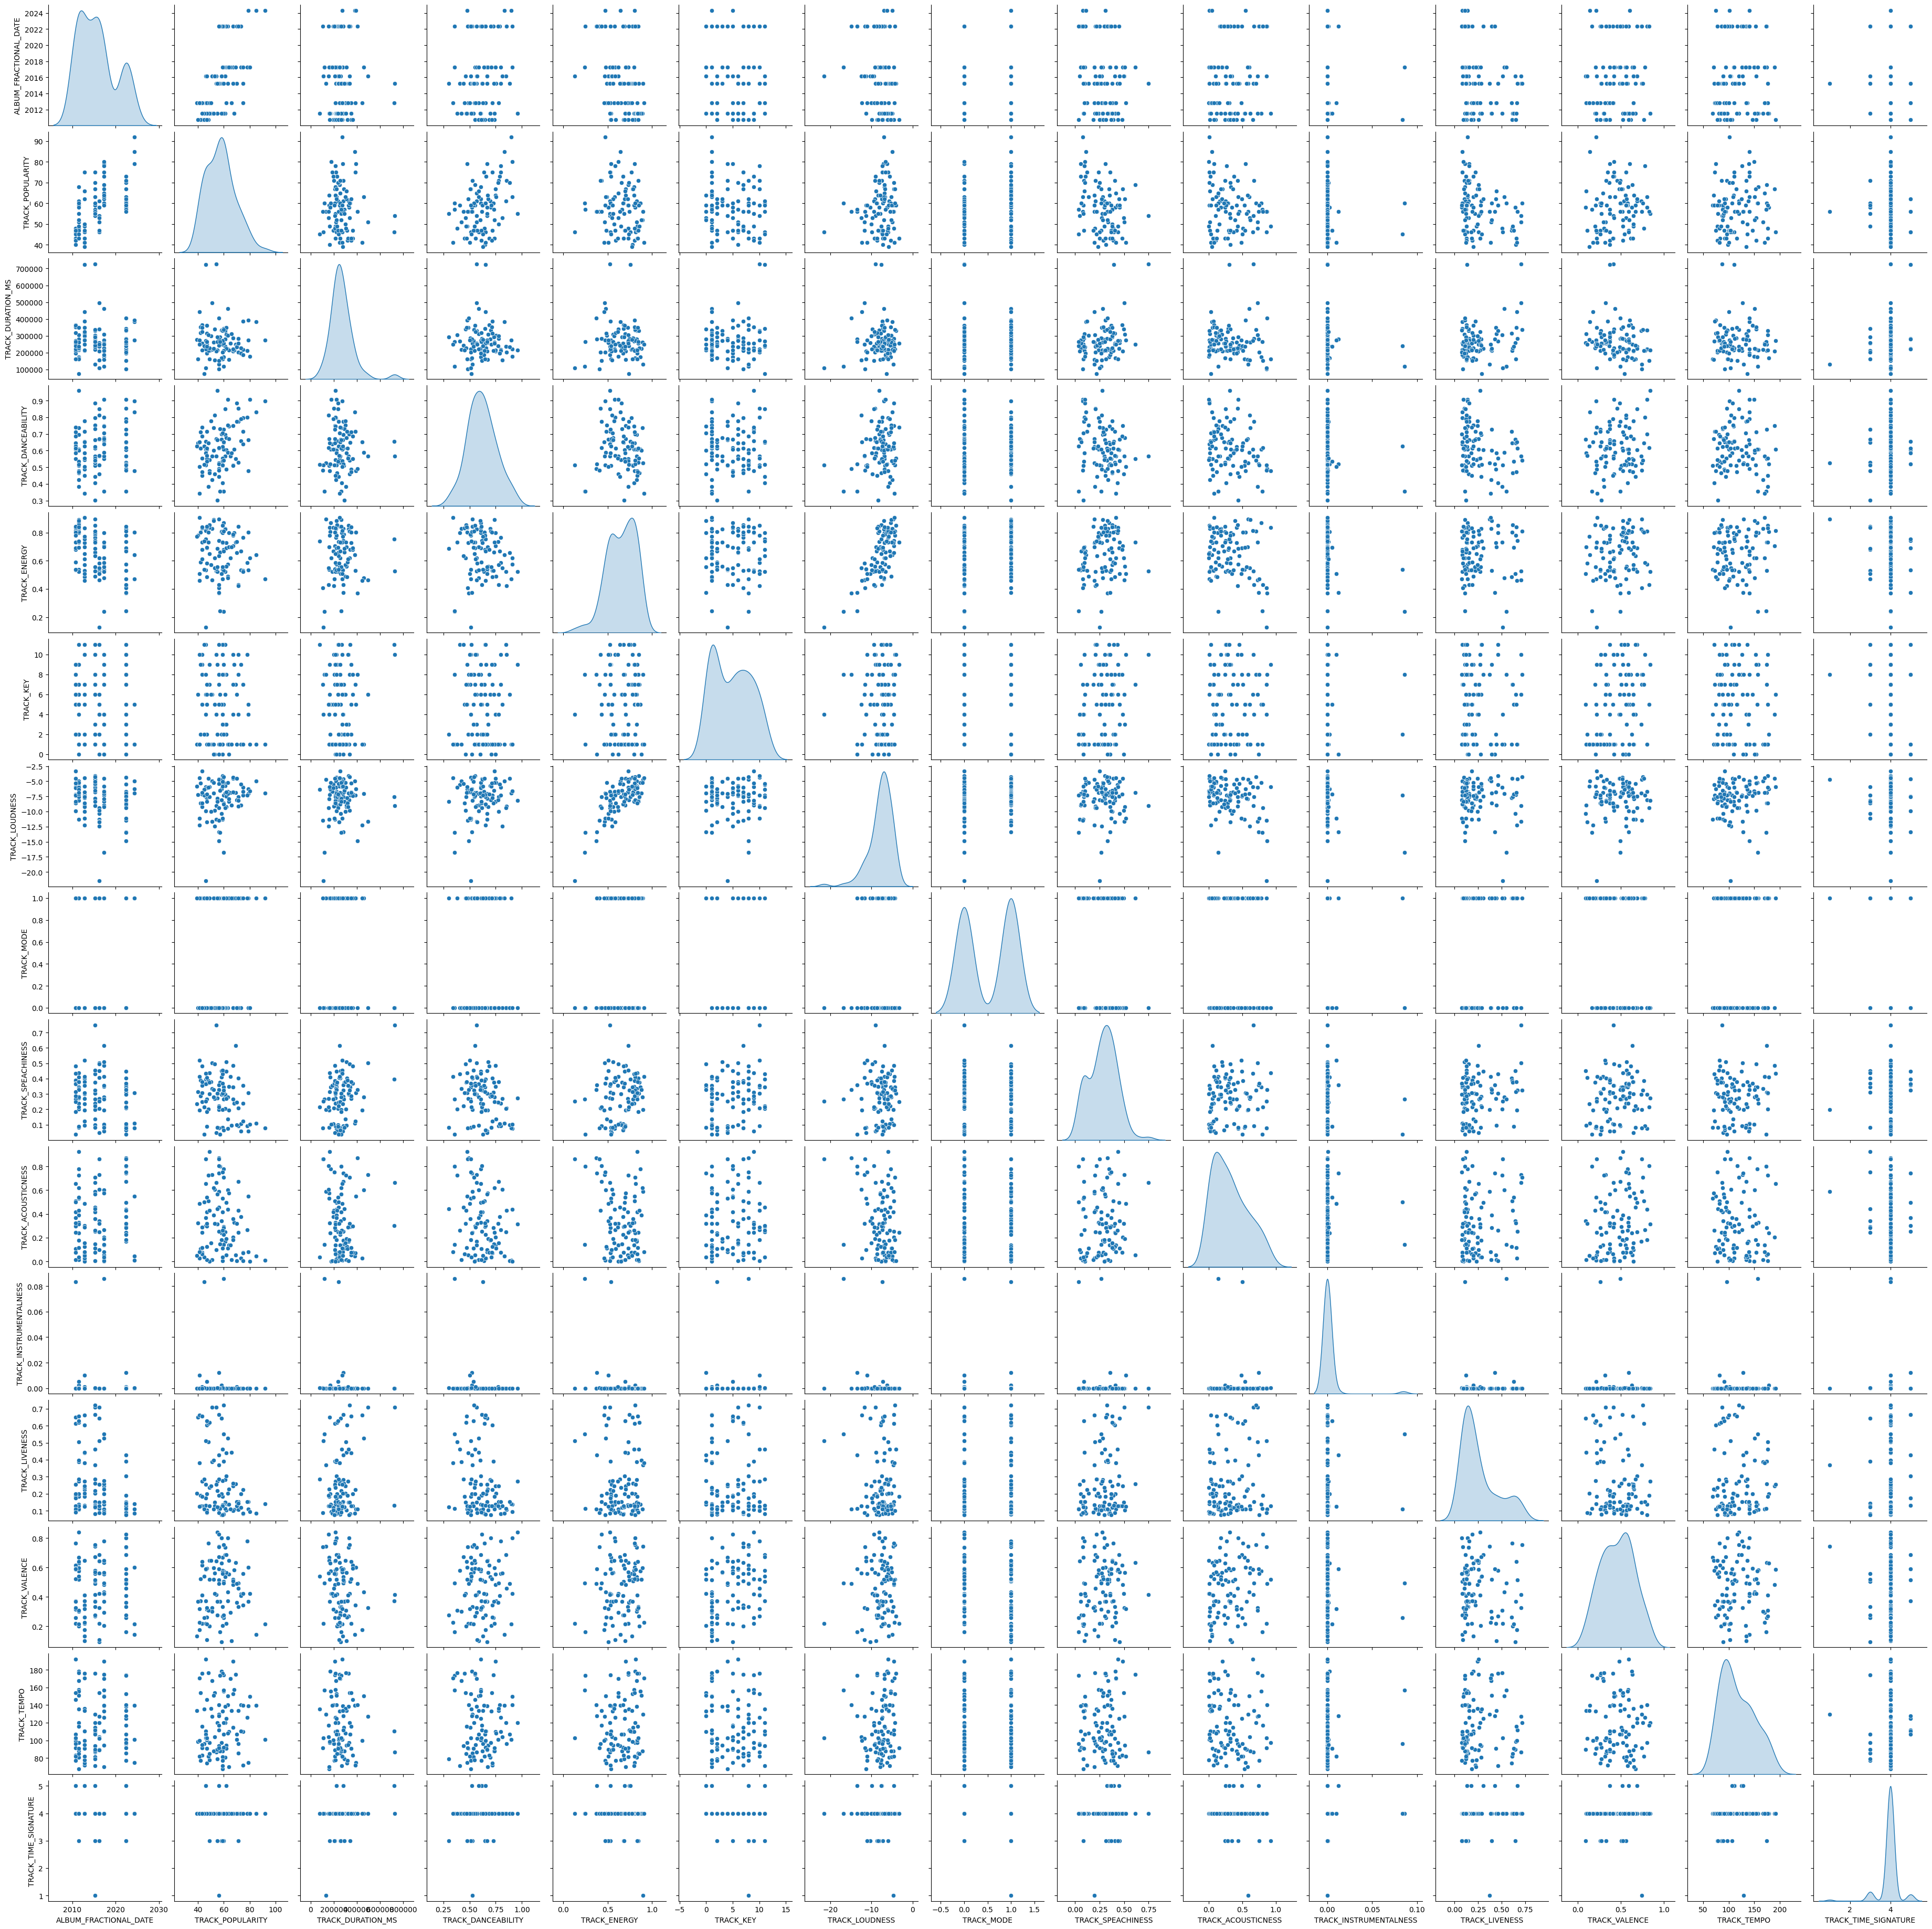

In [37]:
sns.pairplot(cleaned_df, kind='scatter', diag_kind='kde')#.savefig('Outputs/01_pairplot.png')

The pairplot above has A LOT of information, so let's break down what it is that we are seeing.

Feature Analysis:
- TRACK_TIME_SIGNATURE: An overwhelming amount of K Dot's songs are in a value of  4 for this feature. 
   Which the definition is:
   - >"An estimated time signature. The time signature (meter) is a notational convention to specify 
      how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating 
      time signatures of "3/4", to "7/4"." 

   - For Kendrick, this means there are 4 beats in each measure and a quarter note receives one count. 
      According to https://www.skoove.com/, they say that a:

- Skoove: "4/4 time signature gives music a steady, marching rhythm, perfect for getting your foot tapping."
    
- TRACK_TEMPO: When looking at tempo and duration, it seems that the much
   longer songs of K Dot tend to be in lower tempo, which makes sense. His
   longer songs tend to be more poetically-inclined and are of spoken-word
   instead of something like Money Trees for example.

- TRACK_DANCEABILITY: For danceability, the middle ground of tempo seems to be the best.

   - Overall, nothing too great here, even the aformentioned call outs, are sparse and not very 
      linear/direct. So, they are to be taken with a grain of salt. The biggest value is that,
      by looking at the kernel density plot, most of his songs are slower tempo, 
      hence the plot is right-skewed a bit.
    
- TRACK_VALENCE: I just want to call out, this is probably my favorite measure because it 
   algorithmically places a valuue on how positive the song is based on the tone. As Spotify 
   calls out in the documentation: "Tracks with high valence sound more positive 
   (e.g. happy, cheerful, euphoric), while tracks 
   with low valence sound more negative 
   (e.g. sad, depressed, angry) "

   - When looking at popularity it seems to have a relatively strong linear relationship
   with "happier" songs being more popular. With a couple songs being VERY popular and low
   valence.

   - Valence distribution is overall pretty normal. But nothing else to note.

- TRACK_LOUDSNESS & TRACK_ENERGY: Both seem VERY positively correlated to each other.

    
- TRACK_POPULARITY: What is a little troublesome, is that popularity is a mathematical value that
   decreases over time. Let's see if we can reverse-engineer some of that logic
   in the later code.

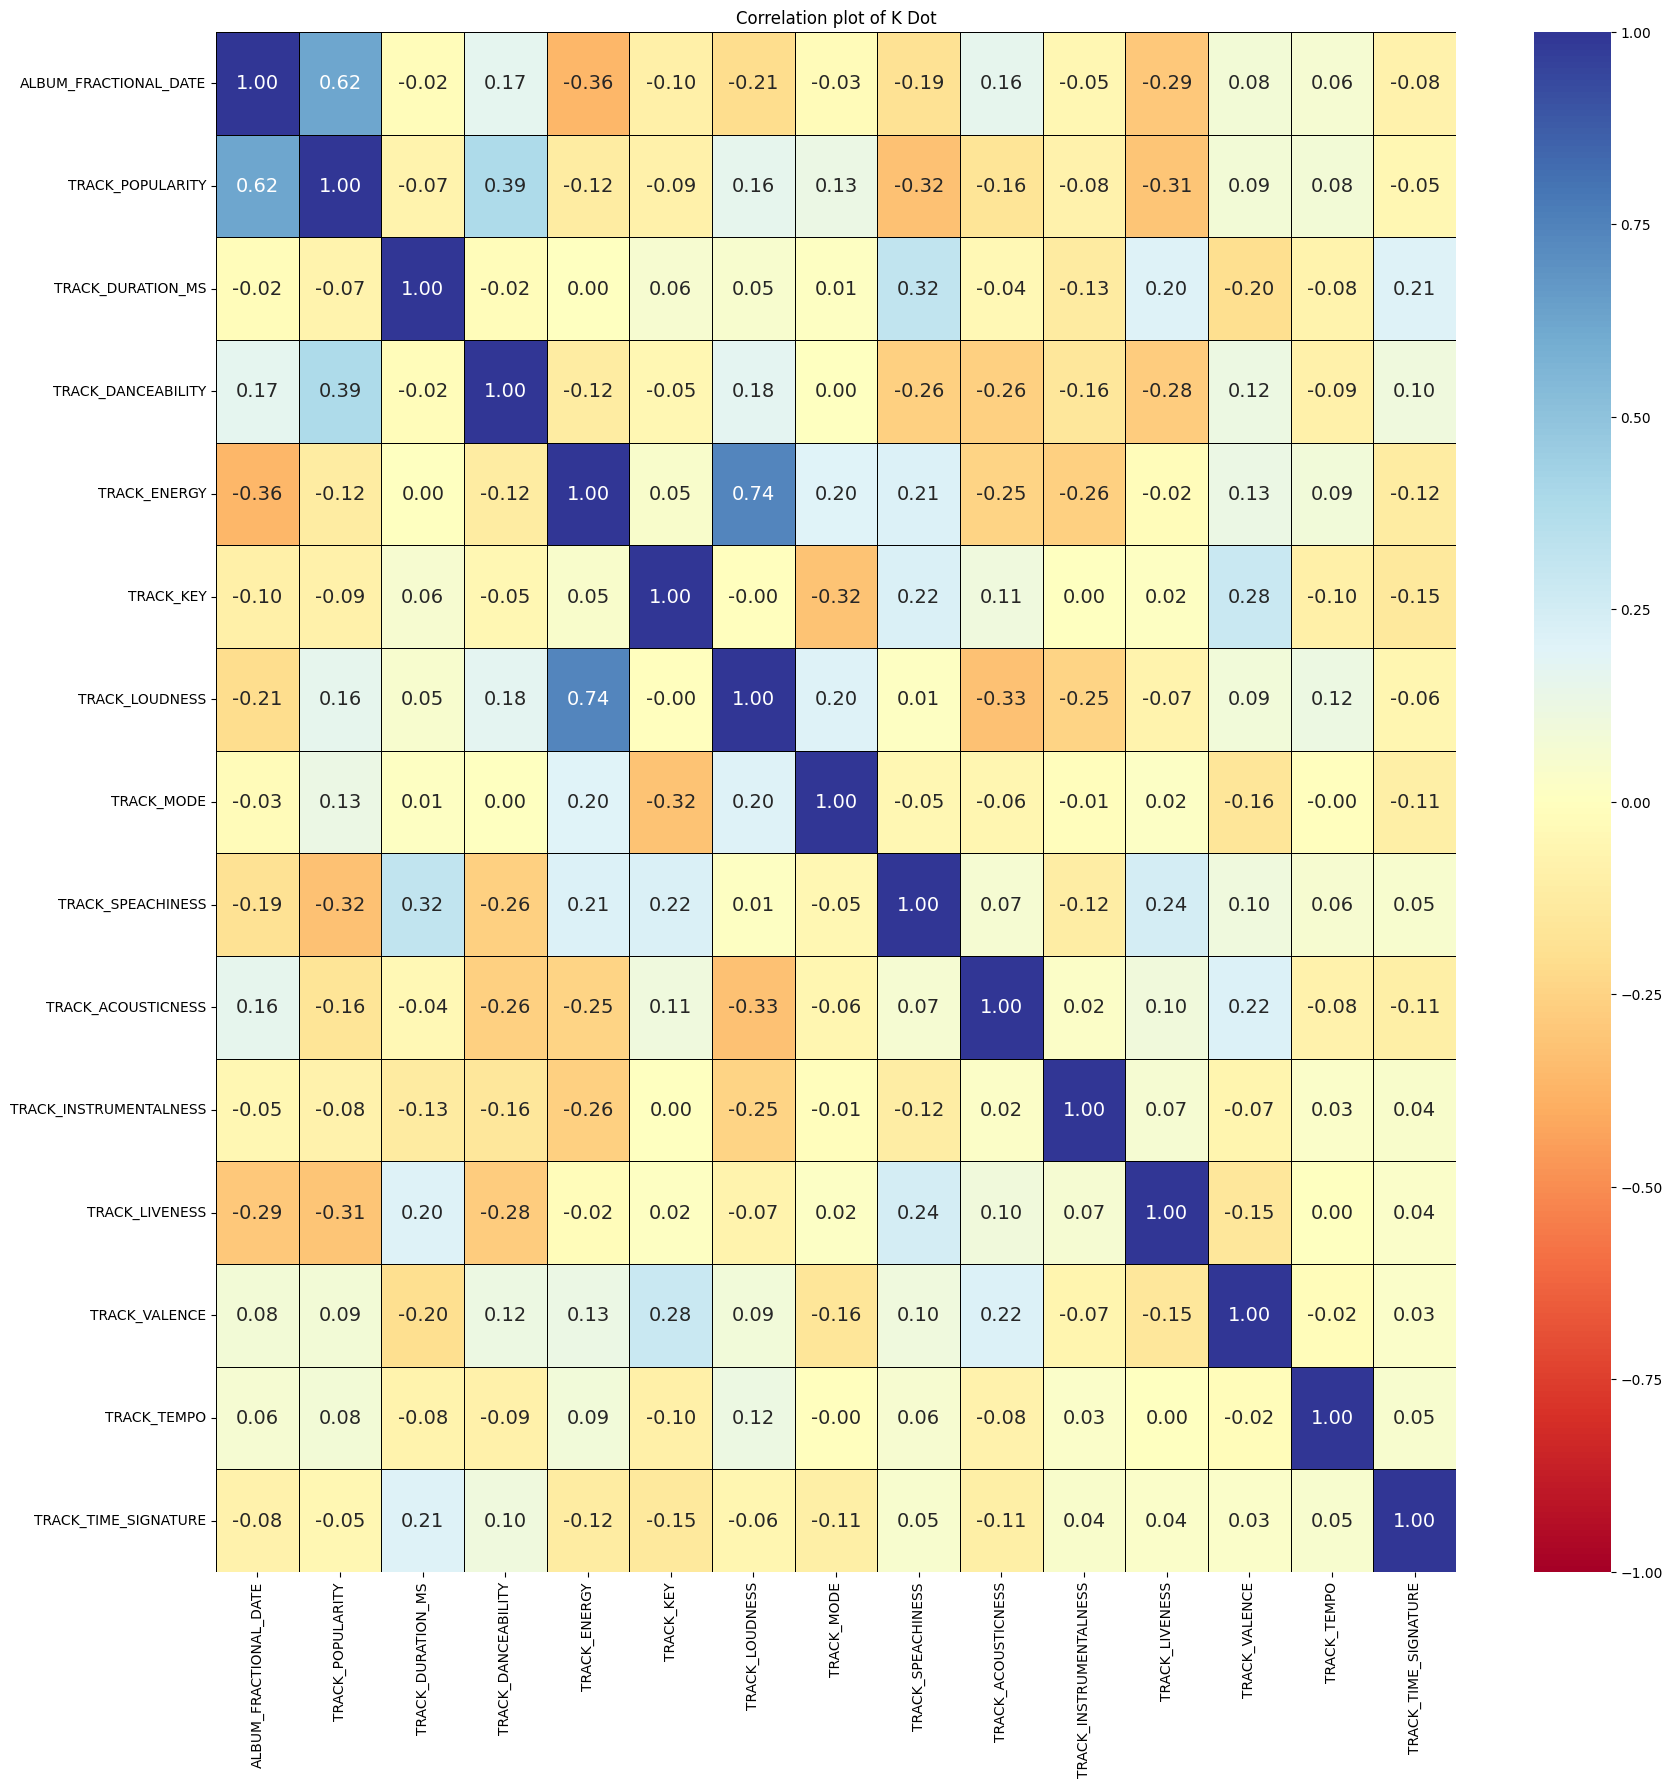

In [38]:
# Let's now boil the ocean again, but instead of a graphical view, let's do a 
# numerical representation using a correlation matrix.
plt.figure(figsize=(20, 20))
sns.heatmap(cleaned_df.corr(numeric_only=True), annot=True, 
            linecolor='black', cmap='RdYlBu', 
            linewidths=0.5,  fmt=".2f",
            vmin=-1, vmax=1, center=0,        
            annot_kws={"size": 14})
plt.title('Correlation plot of K Dot')
#plt.savefig("Outputs/02_corrplot.png")
plt.show()

What is all of that mess even showing besides pretty squares..?

Well, in summary, it is showing that the below relationships are very strongly-related:

- ALBUM_FRACTIONAL_DATE and TRACK_POPULARITY: As we would expect with his most-recent drops
- TRACK_ENERGY and TRACK_LOUDNESS: As we had called out earlier.
 - Both of the above are positive correlations.

Weaker, but worth calling out (negative) correlations:
- TRACK_ENERGY and ALBUM_FRACTIONAL_DATE: Looks like K Dot has a negative trend on 'energy' (no pun intended)
- TRACK_SPEACHINESS and TRACK_POPULARITY: Very 'speachie' tracks are less popular, BUT this makes A LOT
    of sense because his more speachie songs are also much longer and tend to be more poetery/spoken word
    than a hype song.

    
Nothing else exceptional.

In [39]:
# Let's reverse-engineer some of the algorithmicness of popularity.
# We will do this with the consideration that Money Trees and Not Like Us should
#   have a similar value in popularity, much closer than what is currently showing. 
# Or at the very least, Not Like Us should NOT be THAT much popular just because of
# recency.
# This will be done using a modified anti-decay factor/function.

# Define a modified exponential decay function
def antidecay_function(decayed_value, rate_of_decrease, time):
    """
    Where:
        a = Initial Amount
        r = Rate of Decrease
        t = Time
        a = > 0
        r = between 0 and 1 (non-inclusive)
        d = output (decyaed value)

    Original function to give the decay value is:
        d = a(1 - r)**t
    
    For us, it'll be:
        a = d / ( (1 - r)**t )
    """
    return decayed_value / ( (1 - rate_of_decrease) ** time)

In [40]:
today = pd.to_datetime(datetime.now().date())
cleaned_df['DAYS_SINCE_RELEASE'] = today - cleaned_df['ALBUM_RELEASE_DATE']
cleaned_df['SCALED_DAYS_SINCE_RELEASE'] = minmax_scale(cleaned_df[['DAYS_SINCE_RELEASE']])
cleaned_df[['TRACK_NAME', 'DAYS_SINCE_RELEASE', 'SCALED_DAYS_SINCE_RELEASE']].head()

TRACK_NAME DAYS_SINCE_RELEASE  SCALED_DAYS_SINCE_RELEASE
0  We Cry Together           764 days                   0.144951
1      Silent Hill           764 days                   0.144951
2        HiiiPower          4732 days                   0.941578
3         ELEMENT.          2619 days                   0.517366
4     Count Me Out           764 days                   0.144951

In [41]:
# Here we will use an iterative approach
best_rate = 0
lowest_RMSD = np.inf 
for i in np.arange(0.1, 1, .01):
    cleaned_df['ANTI_DECAY_POPULARITY'] = antidecay_function(decayed_value=cleaned_df['TRACK_POPULARITY'],
                                                     rate_of_decrease=i,
                                                     time=cleaned_df['SCALED_DAYS_SINCE_RELEASE'])
    cleaned_df['SCALED_ANTIDECAY_POPULARITY'] = minmax_scale(cleaned_df[['ANTI_DECAY_POPULARITY']])

    #root mean square deviation (broken out for better reading)
    #grab mean value first for distance
    mean_val = cleaned_df['SCALED_ANTIDECAY_POPULARITY'].mean()
    #square the distances
    squared_distances = (cleaned_df['SCALED_ANTIDECAY_POPULARITY'] - mean_val)**2
    #Average distances and square root.
    #We want to minimize this value to find our ideal rate of decrease.
    RMSD = np.sqrt(squared_distances.mean())

    if RMSD < lowest_RMSD:
        lowest_RMSD = RMSD
        best_rate = i
        print(f'New best rate found! {best_rate}')

    # Plots Comment out. They are histograms, and we are trying to find the most "normal".
    # plt.hist(cleaned_df['SCALED_ANTIDECAY_POPULARITY'])
    # plt.title(f'Rate of Decrease: {i}.\nRMSD: {RMSD}')
    # plt.show()


print(f'Lowest RMSD: {lowest_RMSD}')
print(f'Best Rate of Decay: {best_rate}')


New best rate found! 0.1
New best rate found! 0.44999999999999984
New best rate found! 0.45999999999999985
New best rate found! 0.46999999999999986
New best rate found! 0.47999999999999976
New best rate found! 0.48999999999999977
Lowest RMSD: 0.21355867340959828
Best Rate of Decay: 0.48999999999999977


Looks like we found our best rate of decay to reduce the room mean square difference from mean! Let's cement these findings in our columns now.

In [42]:
cleaned_df['ANTI_DECAY_POPULARITY'] = antidecay_function(decayed_value=cleaned_df['TRACK_POPULARITY'],
                                                     rate_of_decrease=best_rate, #.14
                                                     time=cleaned_df['SCALED_DAYS_SINCE_RELEASE'])
cleaned_df['SCALED_ANTIDECAY_POPULARITY'] = minmax_scale(cleaned_df[['ANTI_DECAY_POPULARITY']]) * 100


# Let's take a look at how our songs were ranked with our new values.
with pd.option_context('display.max_rows', 100):
    display(cleaned_df[['ALBUM_NAME', 'TRACK_NAME', 'TRACK_POPULARITY', 'SCALED_ANTIDECAY_POPULARITY']].sort_values(by='SCALED_ANTIDECAY_POPULARITY', ascending=False)
    )

ALBUM_NAME  \
26         good kid, m.A.A.d city   
6                      Section.80   
5             To Pimp A Butterfly   
38         good kid, m.A.A.d city   
2                      Section.80   
30                          DAMN.   
32                     Section.80   
15                          DAMN.   
16                     Section.80   
20                          DAMN.   
27            To Pimp A Butterfly   
37         good kid, m.A.A.d city   
41                     Section.80   
34                          DAMN.   
28            To Pimp A Butterfly   
42                     Section.80   
12                          DAMN.   
22            To Pimp A Butterfly   
72                     Section.80   
60                     Section.80   
11                          DAMN.   
51                     Section.80   
3                           DAMN.   
64            To Pimp A Butterfly   
78               Overly Dedicated   
53            To Pimp A Butterfly   
54            To Pimp A Butterfly   
59            To Pimp A Butterfly   
50            To Pimp A Butterfly   
68                     Section.80   
86                     Section.80   
77               Overly Dedicated   
93               Overly Dedicated   
83               Overly Dedicated   
25                          DAMN.   
7                     Not Like Us   
19           untitled unmastered.   
9                           DAMN.   
31                          DAMN.   
79                     Section.80   
76               Overly Dedicated   
85               Overly Dedicated   
56            To Pimp A Butterfly   
29                          DAMN.   
91                     Section.80   
74         good kid, m.A.A.d city   
89               Overly Dedicated   
46            To Pimp A Butterfly   
43            To Pimp A Butterfly   
58            To Pimp A Butterfly   
17                          DAMN.   
44           untitled unmastered.   
71         good kid, m.A.A.d city   
61            To Pimp A Butterfly   
73            To Pimp A Butterfly   
8                        euphoria   
36                          DAMN.   
94                     Section.80   
39            To Pimp A Butterfly   
75               Overly Dedicated   
80               Overly Dedicated   
55                          DAMN.   
69         good kid, m.A.A.d city   
82               Overly Dedicated   
81               Overly Dedicated   
66         good kid, m.A.A.d city   
99                     Section.80   
45           untitled unmastered.   
23  Mr. Morale & The Big Steppers   
49           untitled unmastered.   
48           untitled unmastered.   
10               meet the grahams   
84               Overly Dedicated   
33  Mr. Morale & The Big Steppers   
14  Mr. Morale & The Big Steppers   
4   Mr. Morale & The Big Steppers   
24  Mr. Morale & The Big Steppers   
47           untitled unmastered.   
90         good kid, m.A.A.d city   
95         good kid, m.A.A.d city   
18  Mr. Morale & The Big Steppers   
97         good kid, m.A.A.d city   
92         good kid, m.A.A.d city   
98         good kid, m.A.A.d city   
88           untitled unmastered.   
1   Mr. Morale & The Big Steppers   
96         good kid, m.A.A.d city   
87           untitled unmastered.   
21  Mr. Morale & The Big Steppers   
13  Mr. Morale & The Big Steppers   
0   Mr. Morale & The Big Steppers   
35  Mr. Morale & The Big Steppers   
57  Mr. Morale & The Big Steppers   
65  Mr. Morale & The Big Steppers   
40  Mr. Morale & The Big Steppers   
67  Mr. Morale & The Big Steppers   
52  Mr. Morale & The Big Steppers   
62  Mr. Morale & The Big Steppers   
70  Mr. Morale & The Big Steppers   
63  Mr. Morale & The Big Steppers   

                                           TRACK_NAME  TRACK_POPULARITY  \
26                                        Money Trees                75   
6                                             A.D.H.D                68   
5                                             Alright       

### Section Takeaway:

Though it reduces the score of Not Like Us, for example, by A LOT simply because 
it's much too new when compared to something like Money Trees, I can't say I entirely 
disagree with the new values. 

A similar metric could've been achieved with total play counts I believe, and arriving
to another mathematical way of popularity, but I think this way makes sense. 

What was surprising to me, was how his album "Mr. Morale & The Big Steppers" (MMTBS)
was basically clustered all the way to the bottom of lowest popularity. I imagine this 
must be, in part, because MMTBS is not very old when looking at albums like GKMC.
Additionally, some people hint at MMTBS having been "a flop" in commercial terms. 

What I certainly do not agree with (on the original popularity ranking) is how
albums were being clustered and sorted almost just by how old they were instead of their
actual popularity, grossly misidentifying the most-popular songs. I think the new 
value we've arrived at does a strong job of identifying truly popular songs, 
but harshly punishes songs that are relatively recent AND NOT highly popular.

This gives me confidence to preceed with our new popularity ranking.

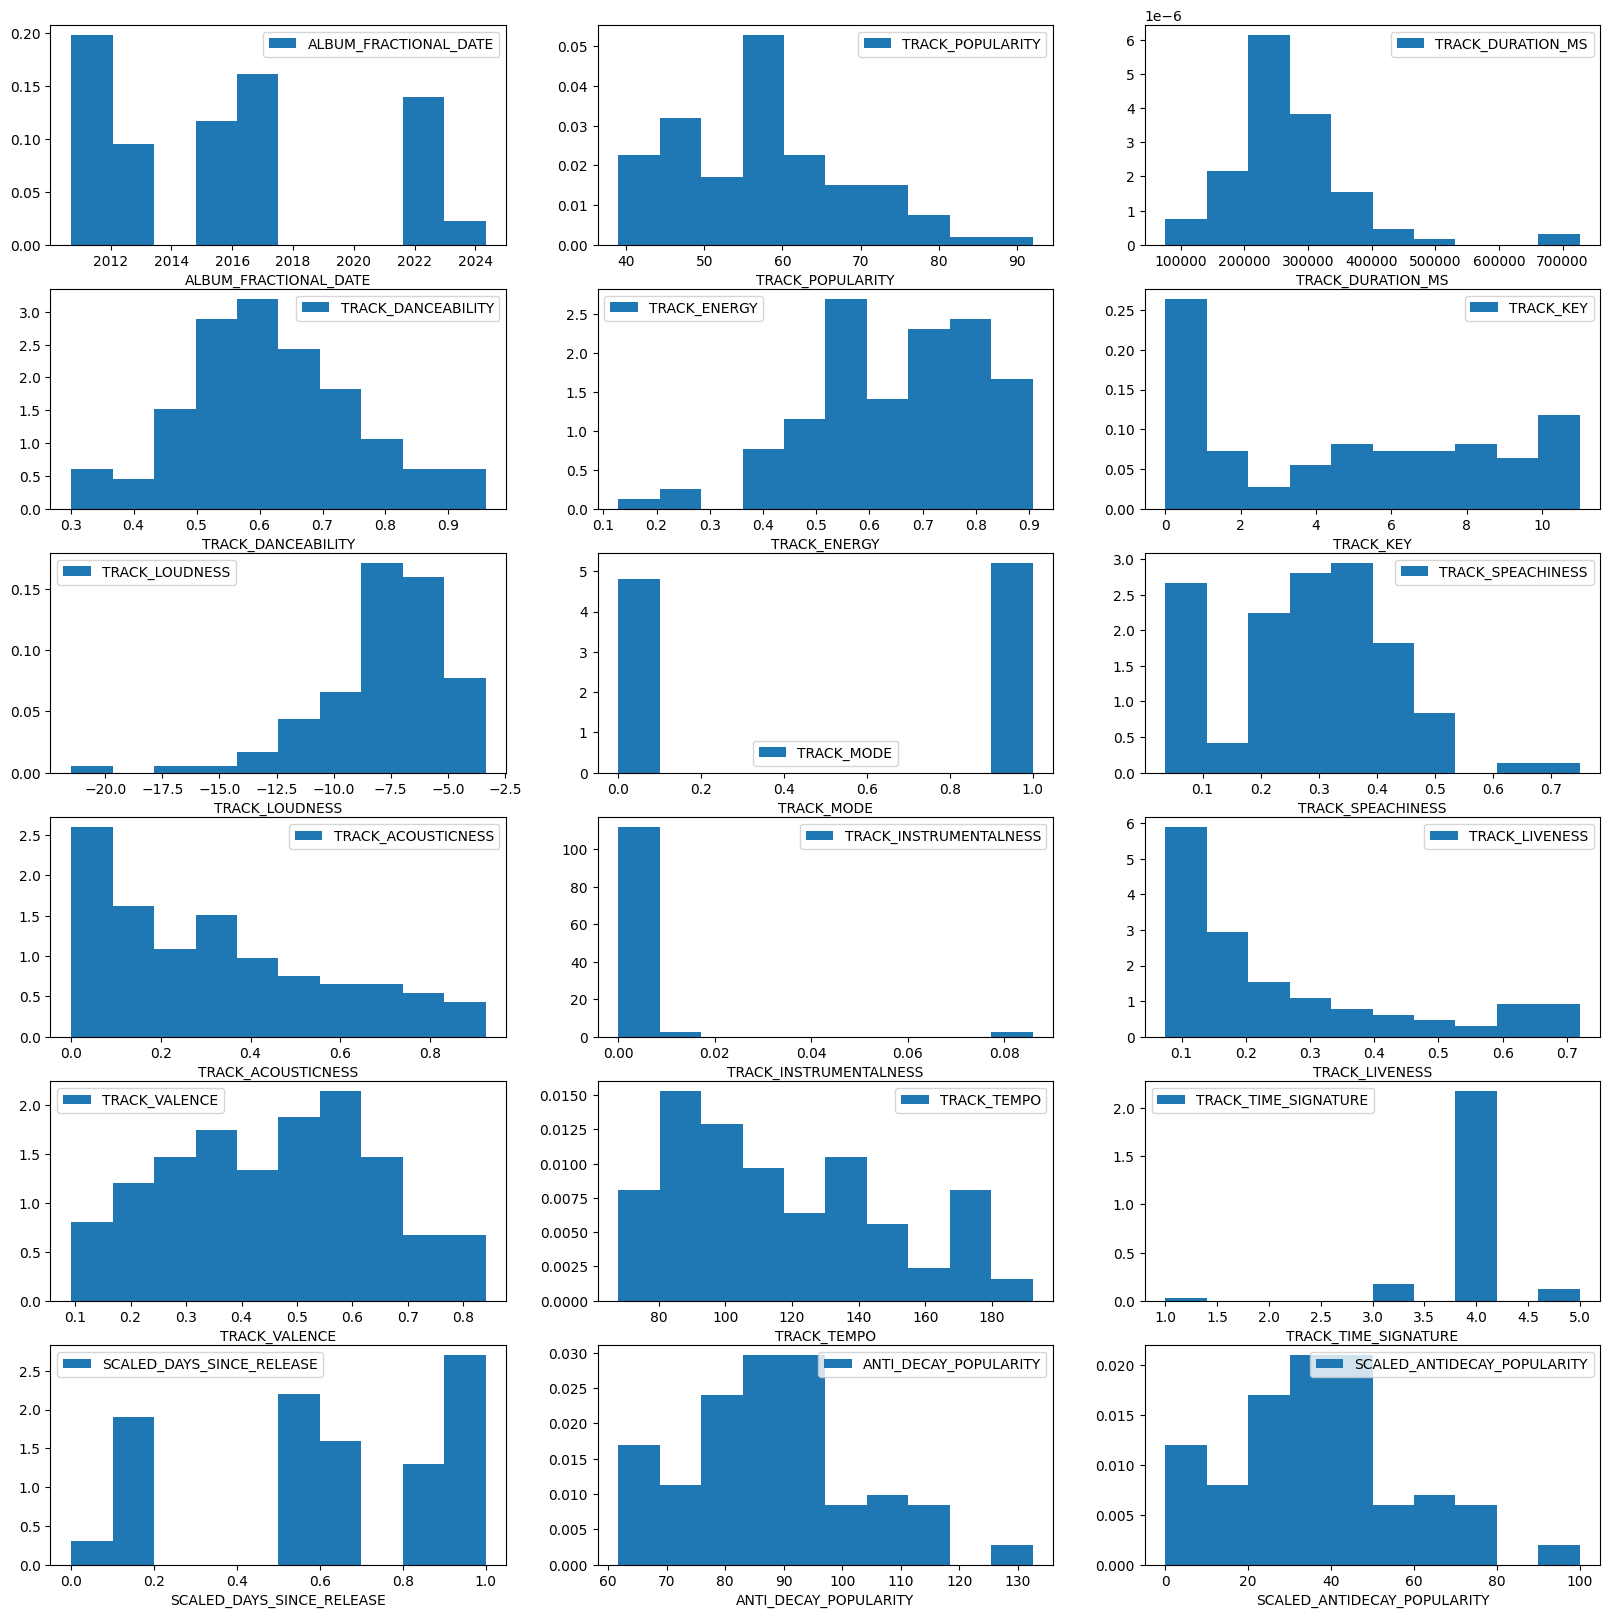

In [43]:
plt.figure(figsize=(20,20))
for num, i in enumerate(cleaned_df.select_dtypes(include=['int', 'float']), start=1):
    plt.subplot(6, 3, num)
    plt.hist(cleaned_df[i], density=True, label=str(i))
    plt.legend()
    plt.xlabel(str(i))

plt.show()

Above is a simple histogram plot of each numeric column from the dataset.

Nothing ~too~ critical. Namely, Kendrick's track danceability seem to follow a 
relatively normal distribution, while his songs tend to lean towards loud and his
acousticness and liveness tend to not be very high.


Additionally, most of his songs fall between the 200K - 300K MS duration. Though,
a few songs have a much longer duration of more than double that.

However, now we can see the visual transformation from the raw (originall) track popularity 
to our anti-decay value, and finally our scaled anti-decay value to bring it back
into a range of 0-100. 

So, now it's worth calling out for consistency, that the SCALED_ANTIDECAY_POPULARITY
is not a relative value. I.e., a value of 0 is that the song has never been listened to,
it's just showing:
     "This is the least popular song of K Dot's discography, when accounting
    for the amount of days the song has been released using the decay function."

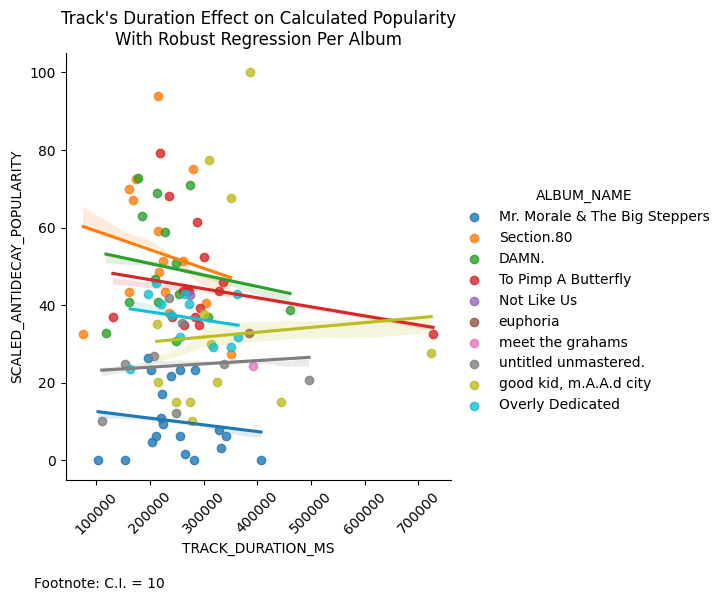

In [44]:
lm_plot = sns.lmplot(data=cleaned_df, x='TRACK_DURATION_MS', 
                     y='SCALED_ANTIDECAY_POPULARITY',
                     hue='ALBUM_NAME', ci=10, robust=True)
lm_plot.set(title="Track's Duration Effect on Calculated Popularity\nWith Robust Regression Per Album")
plt.xticks(rotation=45)
plt.figtext(0.1, -0.1, 'Footnote: C.I. = 10', wrap=True, horizontalalignment='left', fontsize=10)
plt.show()

What are seeing in the plot above? Well, a lot of extrapolation on very few data 
points, but an interesting extrapolation nonetheless. Naturally, there are going
to be outliers within-albums, so we use a Robust regression to de-weight 
those outliers a bit.

We also only use a very small confidence interval of 10 to not overcrowd the plot
with data.

What I find the most interesting is that the album "untitled unmastered." has an upward 
trend for track duration while "DAMN." has a negative fit for track duration. Now,
kee in mind "DAMN." was released mid 2017, while "untitled unmastered" was released
early 2016. So, not a whole lot of difference I would imagine for the popularity reversal
using the decay function to affect it. Even then, we are looking at the 
within-album trend instead of the between-album trend. 
Which should be controlling for that difference anyway since each album has the
same days since release, and the other difference would be the original popularity
we transformed.

In [45]:
#Check the release dates here
cleaned_df[cleaned_df['ALBUM_NAME'].str.contains('untitled|DAMN.')]\
   .get(['ALBUM_NAME', 'ALBUM_RELEASE_DATE'])\
   .drop_duplicates()

ALBUM_NAME ALBUM_RELEASE_DATE
3                  DAMN.         2017-04-14
19  untitled unmastered.         2016-03-04

What is the opinion of this?

The "DAMN." album, having won the Pulitzer Prize, likely attracted A LOT of
    love from Kendrick's non-core audience. Likely some folks that just wanted to
    listen to the hottest songs, or at least not the longest ones. In the other hand,
    "untitled unmastered." targets K Dot's core audiance in the heart of hearts. 
    His poetic spoken-word approach with a grungy-type feeling filled with mystery appeals
    more to those folks, that want to stick around for the longer songs to learn
    about Kendrick.
    Additionally, just the fact alone that the album's name is "untitled unmastered"
    and all of the tracks are "untitled ## .." goes to show what audience he made it for,
    or at least had in mind.

My theory above can also be best-shown by looking at the mean Acousticness, 
    Speachiness, Energy, and Danceability, over the two different albums
    using the code below:

In [46]:
cleaned_df[cleaned_df['ALBUM_NAME'].str.contains('untitled|DAMN.')]\
        .groupby('ALBUM_NAME')\
        .aggregate('mean', numeric_only=True)\
        .filter(items=['TRACK_ACOUSTICNESS', 'TRACK_INSTRUMENTALNESS', 'TRACK_SPEACHINESS', 
                        'TRACK_ENERGY', 'TRACK_DANCEABILITY'])

TRACK_ACOUSTICNESS  TRACK_INSTRUMENTALNESS  \
ALBUM_NAME                                                         
DAMN.                           0.175444                0.006142   
untitled unmastered.            0.442025                0.000001   

                      TRACK_SPEACHINESS  TRACK_ENERGY  TRACK_DANCEABILITY  
ALBUM_NAME                                                                 
DAMN.                          0.275729      0.584857            0.663000  
untitled unmastered.           0.328387      0.489625            0.638625

In [47]:
table_data = []
for feature in [feat_num for feat_num in cleaned_df.select_dtypes(include=['int', 'float']).columns\
                if feat_num not in ['ALBUM_FRACTIONAL_DATE', 
                                    'TRACK_TIME_SIGNATURE', 
                                    'TRACK_KEY', 'TRACK_MODE', 
                                    'TRACK_TIME_SIGNATURE',
                                    'ANTI_DECAY_POPULARITY',
                                    'SCALED_DAYS_SINCE_RELEASE']]:
    max_track = cleaned_df[cleaned_df[feature] == cleaned_df[feature].max()].get('TRACK_NAME').values[0]
    min_track = cleaned_df[cleaned_df[feature] == cleaned_df[feature].min()].get('TRACK_NAME').values[0]

    max_album = cleaned_df[cleaned_df['TRACK_NAME'] == max_track].get('ALBUM_NAME').values[0]
    min_album = cleaned_df[cleaned_df['TRACK_NAME'] == min_track].get('ALBUM_NAME').values[0]


    # print(f"Song with Max {feature.lower().split(sep='_')[1]}: {max_track}")
    # print(f"Song with Min {feature.lower().split(sep='_')[1]}: {min_track}")
    # print("\n")
    # Decided to print out using a pretty tabulate format, instead of a general print statement.
    table_data.append([feature, 'Max', max_album, max_track])
    table_data.append([feature, 'Min', min_album, min_track])


print(tabulate(table_data, 
               headers=['Feature', 'Type', 'Album Name', 'Track Name'], 
               tablefmt='pretty', stralign='left'))

+-----------------------------+------+-------------------------------+---------------------------------------------------+
| Feature                     | Type | Album Name                    | Track Name                                        |
+-----------------------------+------+-------------------------------+---------------------------------------------------+
| TRACK_POPULARITY            | Max  | Not Like Us                   | Not Like Us                                       |
| TRACK_POPULARITY            | Min  | good kid, m.A.A.d city        | Bitch, Don’t Kill My Vibe - Remix                 |
| TRACK_DURATION_MS           | Max  | To Pimp A Butterfly           | Mortal Man                                        |
| TRACK_DURATION_MS           | Min  | Section.80                    | Chapter Ten                                       |
| TRACK_DANCEABILITY          | Max  | Section.80                    | Blow My High (Members Only)                       |
| TRACK_DANCEABI

There's quite a bit here, but nothing that we haven't quite already examined
in our plots of histograms. However, this is a good way to look at the
extreme ends of our data points in a qualitative standpoint, instead of
purely quantitatively.

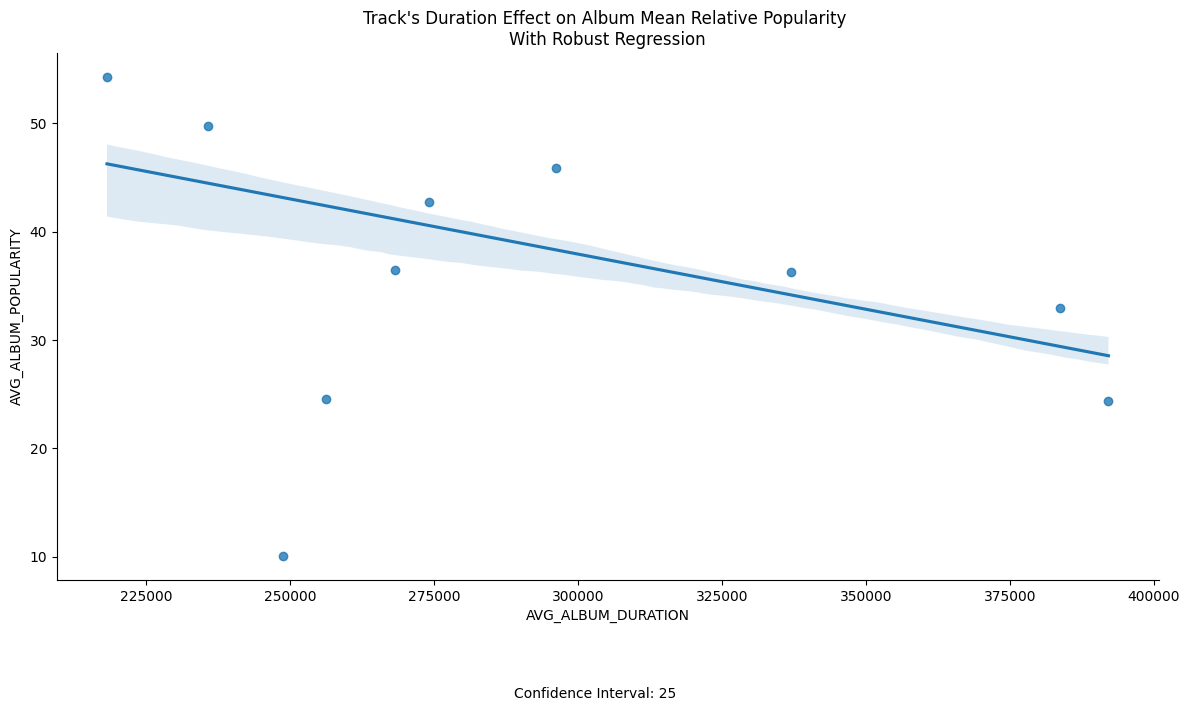

In [48]:
album_pop_and_length = cleaned_df.groupby(['ALBUM_FRACTIONAL_DATE', 'ALBUM_NAME'])\
                        .aggregate(AVG_ALBUM_POPULARITY=('SCALED_ANTIDECAY_POPULARITY', 'mean'),
                                    AVG_ALBUM_DURATION=('TRACK_DURATION_MS', 'mean'))\
                        .reset_index()

lm_plot2 = sns.lmplot(data=album_pop_and_length, 
                      x='AVG_ALBUM_DURATION', y='AVG_ALBUM_POPULARITY', 
                      ci=25, robust=True, aspect=2, height=6)

lm_plot2.set(title="Track's Duration Effect on Album Mean Relative Popularity \nWith Robust Regression")
plt.figtext(0.5, -0.1, "Confidence Interval: 25", fontsize=10, ha='center')
plt.show()

What do we see now? Simply, on average, we see that Kendrick's average album 
popularity tends to decrease as the average album duration increases. 

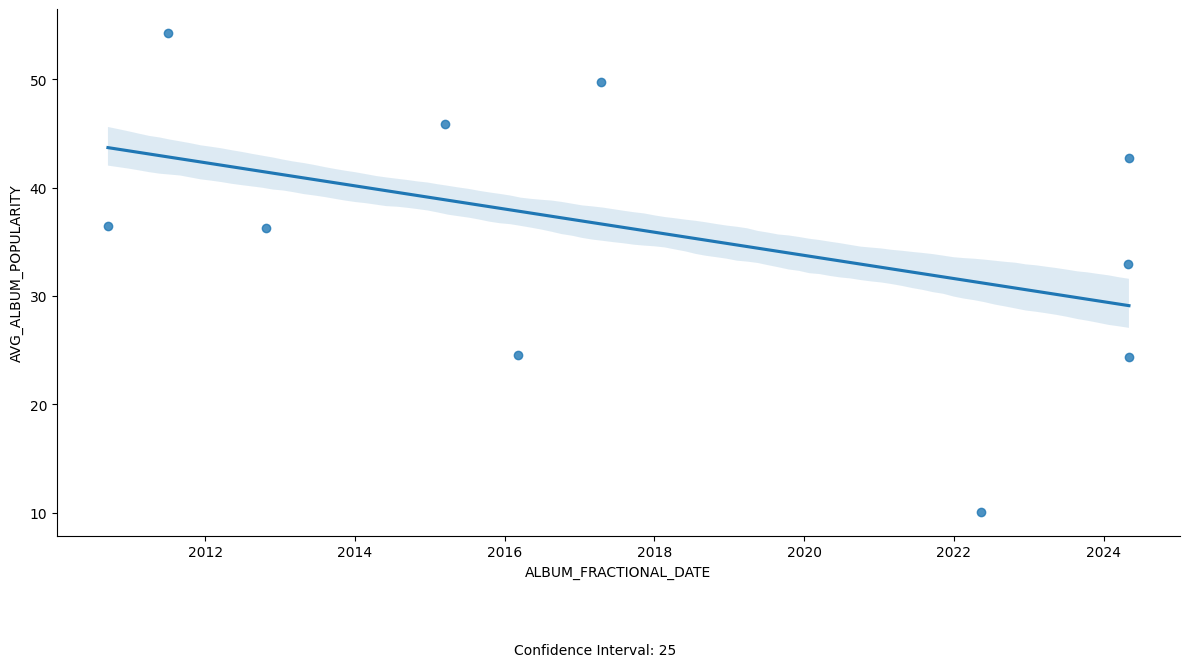

In [49]:
lm_plot3 = sns.lmplot(data=album_pop_and_length, 
                      x='ALBUM_FRACTIONAL_DATE', y='AVG_ALBUM_POPULARITY', 
                      ci=25, robust=True, aspect=2, height=6)

lm_plot2.set(title="Mean Relative Album Popularity Over Time \nWith Robust Regression")
plt.figtext(0.5, -0.1, "Confidence Interval: 25", fontsize=10, ha='center')
plt.show()

Now, this plot above is a bit misleading. If reading it at face value, one would
assume that over time, Kedrick is losing popularity. However, we must keep in mind 
that our y-value in this case, is relative. Moreover, a big part driving this decrease
is because of the last 3 songs not having a lot of time to really yet be established
as truly popular or not, given our anti-decay formula. Lastly, since the value is
relative, we also get the "negative" impact of 'Mr. Morale & The Big Steppers'
being the lowest and after 2022.



For reference, if I had plotted (not shown) the same plot but using the original
popularity value, the line was VERY linearly positive. Which we would expect since the original 
popularity rating was developed that way!


With that, that concludes this section of our code, let's dive into some
machine learning algorithms now!

# Machine Learning Models
For this specific section, we're going to our data a bit and build some machine 
learning models to try and see if it can accurately predict whether I (personally) 
would REALLY like a Kedrick Lamar song, or not so much.

This will be using manually imputted values of 1 on songs I really enjoy, and 
0 on songs I did not enjoy as much.

Though the above is a classification model, the same can be done using
regressions models using a "likeness" value from 0 to 100, for example!

In [50]:
# Let's first manually categorize whether we VERY MUCH like a Kendrick Lamar song
# or not so much. We skip this in our iteration, and use the harded values instead.

favorites = {}

for index, row in cleaned_df.iterrows():
    song = row['TRACK_NAME']
    is_favorite = simpledialog.askinteger('Song Categorizer', 
                            prompt=f'Do you like song: {song}: 0 or 1')
    favorites[song] = is_favorite

In [51]:
# To not have to cycle through again, I will hardcore the results below
favorites =\
{'Alright': 1,
 'Silent Hill': 0,
 'Count Me Out': 0,
 'Not Like Us': 1,
 'meet the grahams': 1,
 'A.D.H.D': 1,
 'FEEL.': 1,
 'HiiiPower': 0,
 'Rich Spirit': 1,
 'ELEMENT.': 1,
 'euphoria': 1,
 'LOYALTY. FEAT. RIHANNA.': 1,
 'These Walls': 0,
 'N95': 1,
 'Father Time (feat. Sampha)': 1,
 'FEAR.': 1,
 'untitled 08 | 09.06.2014.': 0,
 'DUCKWORTH.': 1,
 'Savior': 1,
 'King Kunta': 1,
 'Purple Hearts': 0,
 'PRIDE.': 0,
 'LUST.': 1,
 'We Cry Together': 1,
 "Hol' Up": 0,
 'Die Hard': 1,
 'Chapter Six': 0,
 'XXX. FEAT. U2.': 0,
 'HUMBLE.': 1,
 "Wesley's Theory": 1,
 'YAH.': 1,
 'LOVE. FEAT. ZACARI.': 1,
 'Money Trees': 1,
 'DNA.': 1,
 'United In Grief': 1,
 'Mr. Morale': 0,
 'BLOOD.': 0,
 'm.A.A.d city': 1,
 'Bitch, Don’t Kill My Vibe': 1,
 'The Heart Part 5': 1,
 'Blow My High (Members Only)': 0,
 'u': 1,
 'Rigamortus': 0,
 'Mother I Sober (feat. Beth Gibbons of Portishead)': 1,
 'How Much A Dollar Cost': 0,
 'The Blacker The Berry': 1,
 'Hood Politics': 1,
 'untitled 02 | 06.23.2014.': 0,
 'untitled 03 | 05.28.2013.': 0,
 'Poe Mans Dreams (His Vice) (feat. GLC)': 0,
 'Institutionalized': 0,
 'Momma': 1,
 'Ronald Reagan Era': 0,
 'untitled 07 | 2014 - 2016': 1,
 "You Ain't Gotta Lie (Momma Said)": 1,
 'Complexion (A Zulu Love)': 0,
 'GOD.': 1,
 'i': 1,
 'untitled 06 | 06.30.2014.': 0,
 'Mirror': 0,
 'Mortal Man': 1,
 'For Free? - Interlude': 0,
 'Auntie Diaries': 0,
 'Rich - Interlude': 0,
 'untitled 05 | 09.21.2014.': 0,
 "Tammy's Song (Her Evils)": 1,
 'Crown': 0,
 'Worldwide Steppers': 0,
 'F*ck Your Ethnicity': 1,
 "Sing About Me, I'm Dying Of Thirst": 1,
 'Swimming Pools (Drank) - Extended Version': 1,
 'For Sale? - Interlude': 0,
 'Backseat Freestyle': 1,
 'Savior - Interlude': 1,
 'Poetic Justice': 1,
 'Opposites Attract (Tomorrow W/O Her)': 1,
 'Kush & Corinthians (feat. BJ The Chicago Kid)': 1,
 'Average Joe': 1,
 'Cut You Off (To Grow Closer)': 1,
 'She Needs Me (Remix)': 1,
 'Michael Jordan': 0,
 'P&P 1.5': 0,
 'Growing Apart (To Get Closer)': 1,
 'H.O.C': 0,
 'Ignorance Is Bliss': 0,
 "Keisha's Song (Her Pain) (feat. Ashtro Bot)": 1,
 'R.O.T.C (Interlude)': 0,
 'Chapter Ten': 0,
 'Barbed Wire': 1,
 'No Make-Up (Her Vice) (feat. Colin Munroe)': 1,
 'untitled 04 | 08.14.2014.': 0,
 'Alien Girl (Today W/ Her)': 1,
 'The Art of Peer Pressure': 1,
 'untitled 01 | 08.19.2014.': 1,
 'Ab-Souls Outro (feat. Ab-Soul)': 0,
 'Bitch, Don’t Kill My Vibe - Remix': 0,
 'good kid': 1,
 'Real': 1,
 'Compton': 1,
 'Sherane a.k.a Master Splinter’s Daughter': 1}

In [52]:
cleaned_df['IS_FAVORITE'] = favorites.values()
cleaned_df.groupby('IS_FAVORITE').size() # Check class imbalanced

IS_FAVORITE
0    39
1    61
dtype: int64

Now, our target variable isn't grossly inbalaned, but there is some inbalance nonetheless.

Let's try and correct for that by manually some potentially repetitive songs (Remix versions), 
for example. Any additional differences, will have to be handled differently. 
Whether we use weights for the classes, undersampling, or SMOTE for oversampling. 

Though we will use some models that this inbalance does not matter as much (like random forest),
it should still be corrected for the best approaches.

We are also going to drop unneeded columns and scale all values for learning 
models before we begin.

In [53]:
# Duplicated songs was just 1
songs_to_drop = ['Bitch, Don’t Kill My Vibe - Remix']


# Let's drop that row, and all unneeded columns now.
df_ML = cleaned_df[~cleaned_df['TRACK_NAME'].isin(songs_to_drop)]\
        .drop(columns=['ALBUM_ID', 'ALBUM_NAME', 'ALBUM_RELEASE_DATE',
                       'TRACK_ID', 'TRACK_POPULARITY', 'ALBUM_FRACTIONAL_DATE'])\
        .reset_index(drop=True)\
        .assign(**pd.get_dummies(data=cleaned_df[['TRACK_KEY', 'TRACK_MODE', 
                                    'TRACK_TIME_SIGNATURE']], 
                                drop_first=True, 
                                 columns=['TRACK_KEY', 'TRACK_MODE', 
                                    'TRACK_TIME_SIGNATURE']))\
        .drop(columns=['TRACK_KEY', 'TRACK_MODE', 
                                    'TRACK_TIME_SIGNATURE'])

df_ML = df_ML.reindex(columns=['TRACK_NAME'] +\
                      [col for col in df_ML.columns if col not in ['IS_FAVORITE',
                                                                    'TRACK_NAME']] +\
                                                                 ['IS_FAVORITE']
                    )
df_og = df_ML.copy() #Will be used for index values later on.

This pairplot below is just used as a quick spot-check analysis since we already performed an extensive
EDA on all of the features against the ranking of the song. 

So, what do I infer from it? I would assume our predictive modeling abilities will be akin
to that of a coin flip, or perhaps a bit better, at most. However, we will still run through
several examples, I would feel relatively confident saying we would need more data or better 
features.

Why do I infer that? I do so because when looking at all the scatter plots, none have a very
clear seperation between the classes. Furthermore, when looking at the density plot (diagonals),
we can see that each class (0 and 1) can be very easily sub-sampled from the other in a random
sampling.

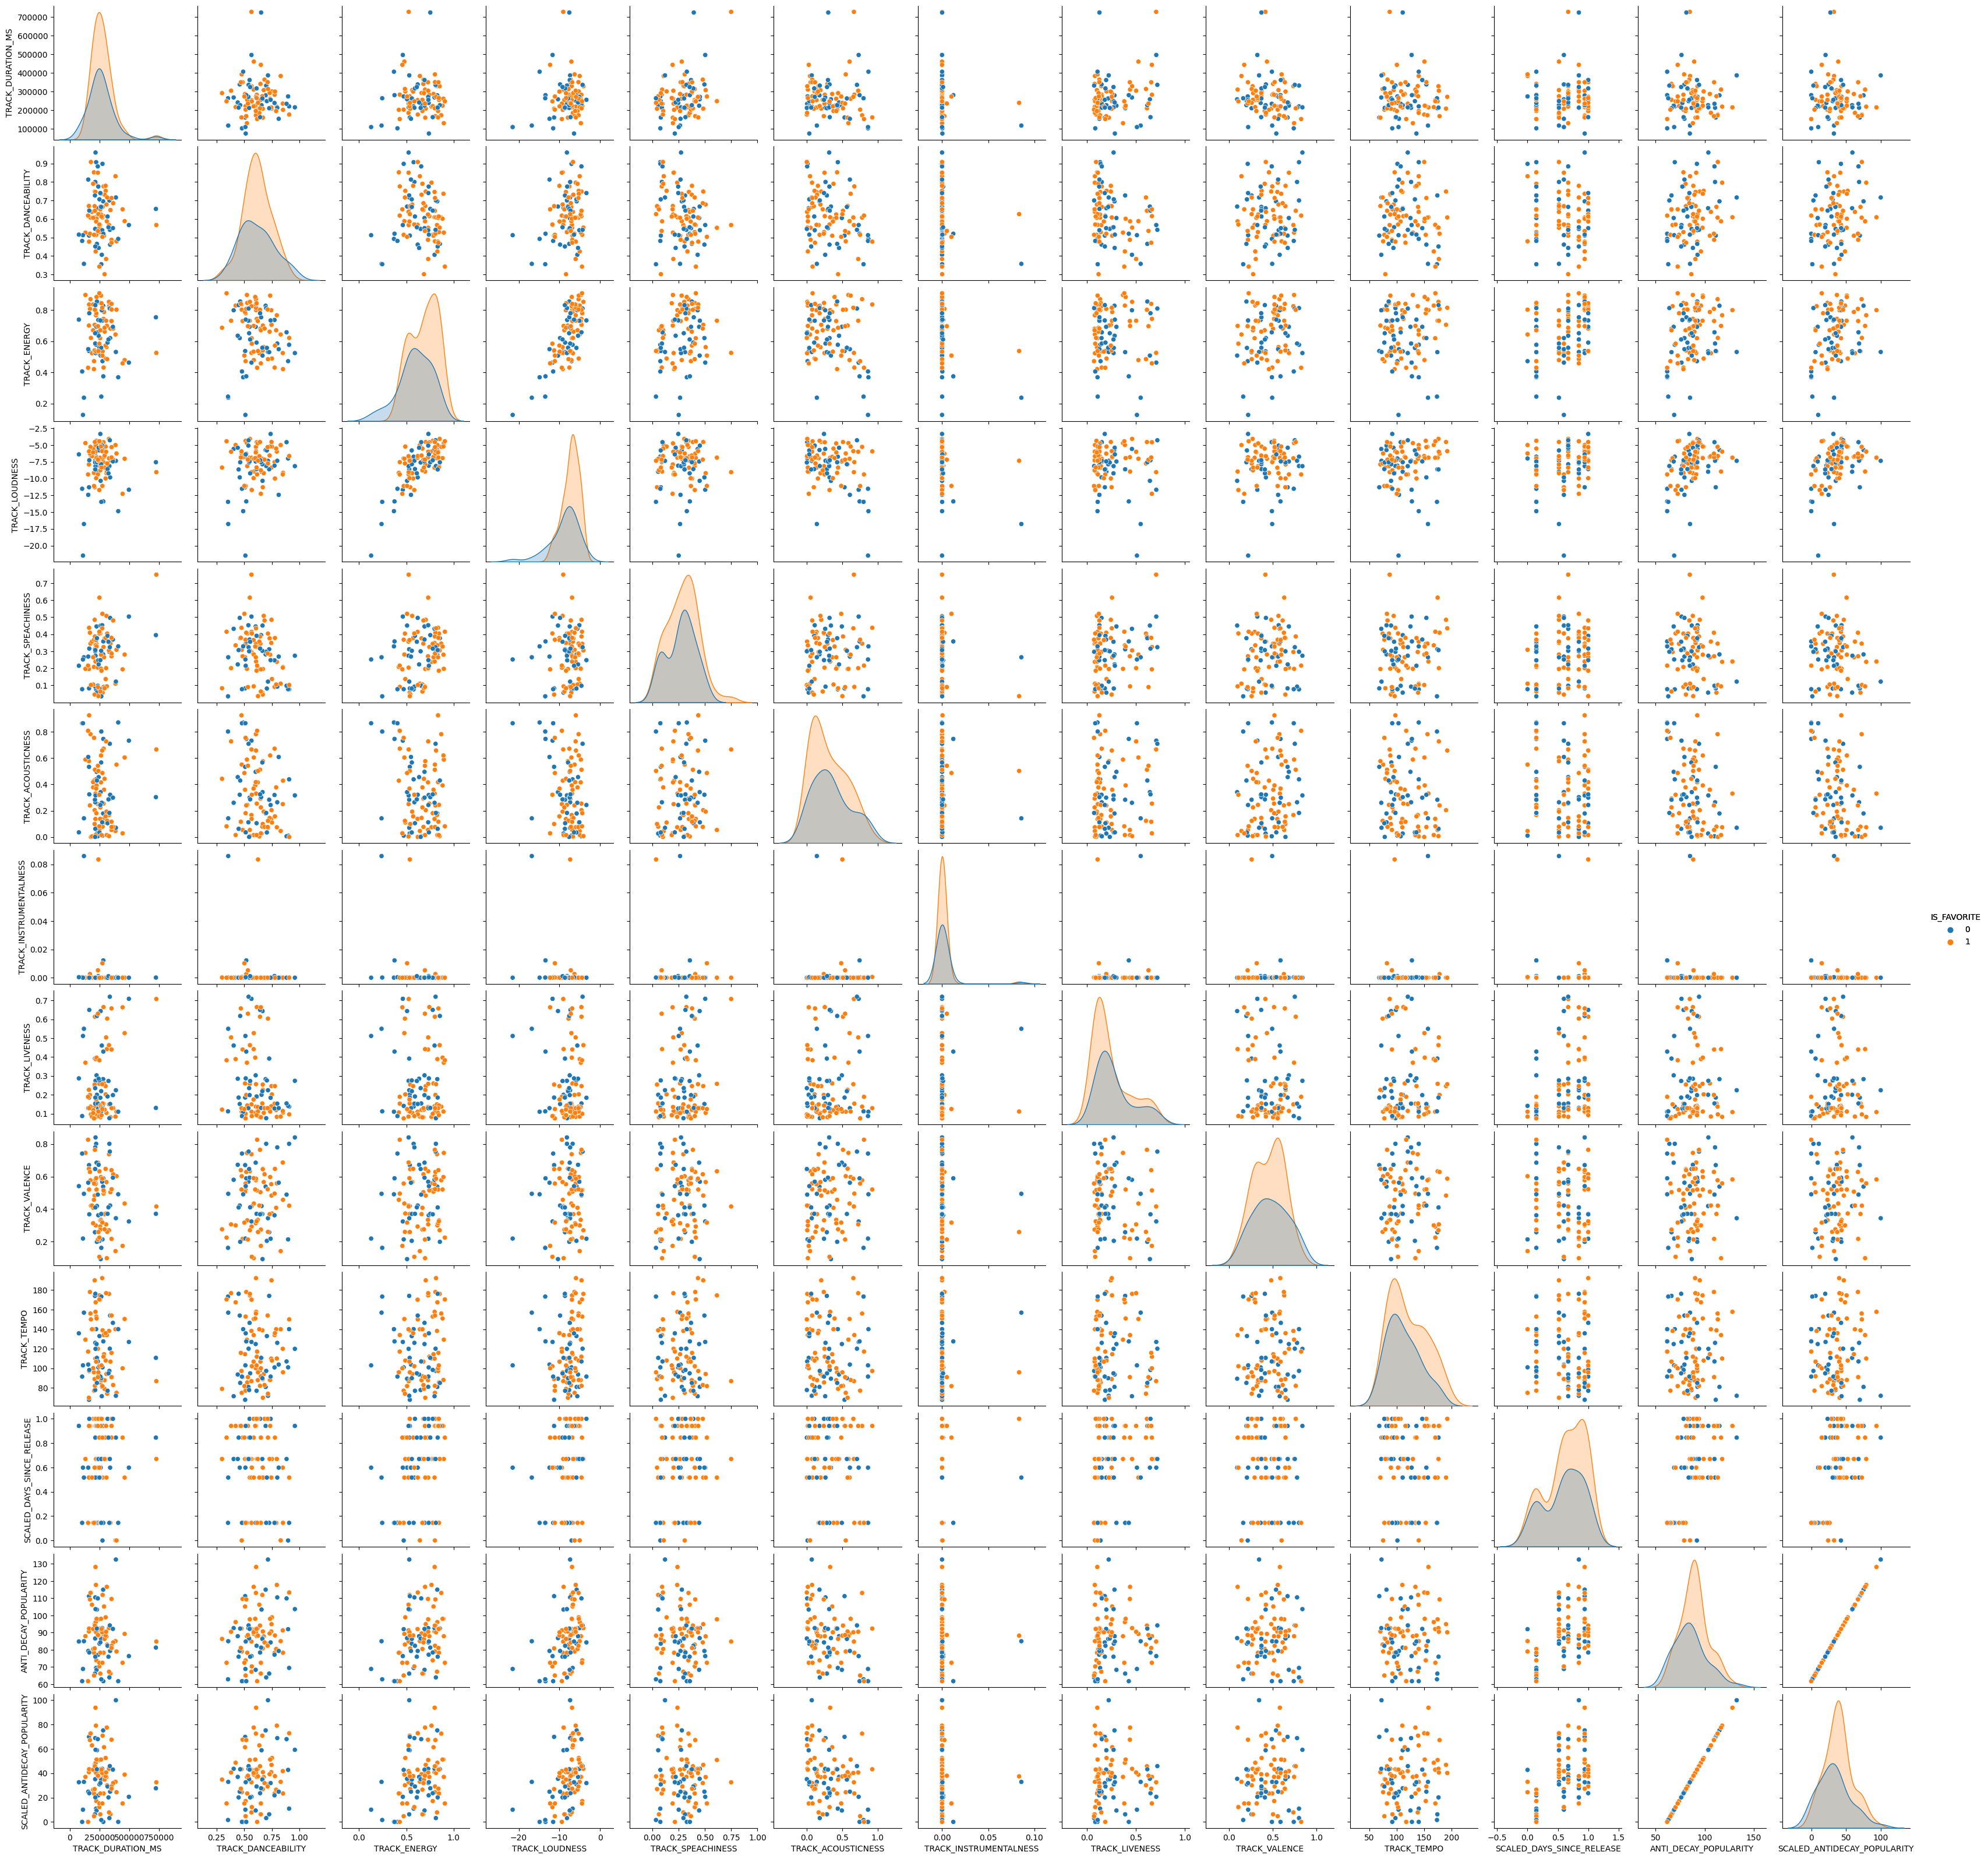

In [54]:
sns.pairplot(df_ML.select_dtypes([int, float]), hue='IS_FAVORITE').add_legend()

## Data Splitting

In [55]:
# First things first, we need to split the data. Then we will standardize after
# to avoid data leakage.
X = df_ML.drop(columns=['TRACK_NAME', 'IS_FAVORITE'])
y = df_ML['IS_FAVORITE']



X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=5)


## Scaling The Data

In [56]:
# Now we can scale the data
cols_to_scale = ['TRACK_DURATION_MS',
                'TRACK_DANCEABILITY',
                'TRACK_ENERGY',
                'TRACK_LOUDNESS',
                'TRACK_SPEACHINESS',
                'TRACK_ACOUSTICNESS',
                'TRACK_INSTRUMENTALNESS',
                'TRACK_LIVENESS',
                'TRACK_VALENCE',
                'TRACK_TEMPO']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[cols_to_scale])
X_test_scaled = scaler.transform(X_test[cols_to_scale])



# Let's keep it in pandas dataframe for better visuals
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cols_to_scale, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cols_to_scale, index=X_test.index)


X_train_final = pd.concat([X_train_scaled_df, X_train.drop(columns=cols_to_scale + ['DAYS_SINCE_RELEASE'])], axis=1)
X_test_final = pd.concat([X_test_scaled_df, X_test.drop(columns=cols_to_scale + ['DAYS_SINCE_RELEASE'])], axis=1)
y_train_final = pd.DataFrame(y_train)
y_test_final = pd.DataFrame(y_test)


with pd.option_context('display.max_columns', None): 
    display(X_train_final.head())

TRACK_DURATION_MS  TRACK_DANCEABILITY  TRACK_ENERGY  TRACK_LOUDNESS  \
6           -0.615918            0.023669      0.899386        0.299976   
88          -0.196263           -0.252060     -0.489578       -1.489189   
64           0.952780           -0.457088      0.963989        1.262973   
26           1.615295            0.780155     -0.831974        0.124953   
48           0.984192           -1.022685     -0.257008       -0.789839   

    TRACK_SPEACHINESS  TRACK_ACOUSTICNESS  TRACK_INSTRUMENTALNESS  \
6           -0.300835            0.012008               -0.183282   
88           0.883838           -0.023741               -0.183282   
64           0.302271            1.513470               -0.183282   
26          -1.148056           -1.019551               -0.183282   
48           1.537203           -0.023741               -0.183282   

    TRACK_LIVENESS  TRACK_VALENCE  TRACK_TEMPO  SCALED_DAYS_SINCE_RELEASE  \
6        -0.816393       0.747952     1.101890                   0.941578   
88       -0.923890      -1.914457    -0.492742                   0.598876   
64        2.286831       1.706420     0.021214                   0.669946   
26       -0.228200      -0.586055    -1.359556                   0.845613   
48       -0.598356      -0.148859     0.992835                   0.598876   

    ANTI_DECAY_POPULARITY  SCALED_ANTIDECAY_POPULARITY  TRACK_KEY_1  \
6              128.190075                    93.857195            0   
88              70.343987                    12.151041            0   
64              94.202707                    45.850886            0   
26             132.539040                   100.000000            0   
48              79.324071                    24.835185            0   

    TRACK_KEY_2  TRACK_KEY_3  TRACK_KEY_4  TRACK_KEY_5  TRACK_KEY_6  \
6             0            0            0            0            0   
88            1            0            0            0            0   
64            0            0            0            0            0   
26            0            0            0            0            0   
48            0            0            0            0            0   

    TRACK_KEY_7  TRACK_KEY_8  TRACK_KEY_9  TRACK_KEY_10  TRACK_KEY_11  \
6             0            0            1             0             0   
88            0            0            0             0             0   
64            0            1            0             0             0   
26            1            0            0             0             0   
48            0            0            0             0             0   

    TRACK_MODE_1  TRACK_TIME_SIGNATURE_3  TRACK_TIME_SIGNATURE_4  \
6              1                       0                       1   
88             1                       0                       1   
64             1                       0                       1   
26             1                       0                       1   
48             1                       0                       1   

    TRACK_TIME_SIGNATURE_5  
6                        0  
88                       0  
64                       0  
26                       0  
48                       0

## Random Forest

Num of estimators:  100
Best Score:  0.41666666666666663


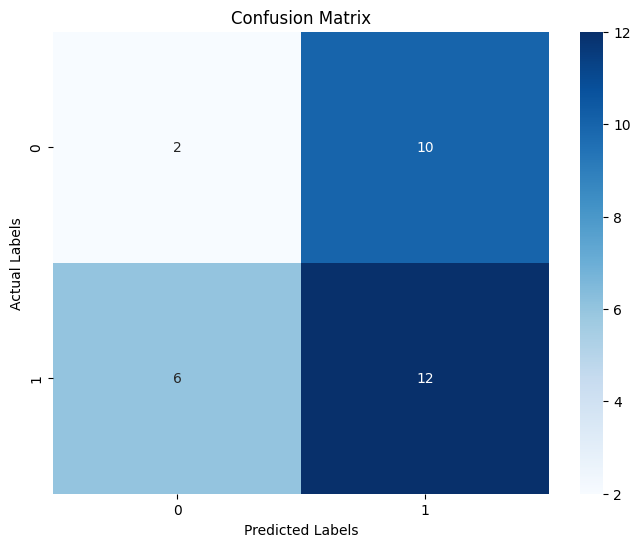

In [57]:
best_rf = None
best_rf_accuracy = 0
best_rf_predict = None

for est in [50, 100, 150, 200, 250]:
    rf = RandomForestClassifier(n_estimators=est, 
                                class_weight='balanced', 
                                random_state=5)
    
    rf.fit(X_train_final, y_train_final.to_numpy().ravel())
    rf_predict = rf.predict(X_test_final)
    rf_balanced_accuracy = balanced_accuracy_score(y_test_final, rf_predict)
    if  rf_balanced_accuracy > best_rf_accuracy:
        best_rf_accuracy = rf_balanced_accuracy
        best_rf_predict = rf_predict
        best_rf = rf

print('Num of estimators: ', best_rf.n_estimators)
print('Best Score: ', best_rf_accuracy)


rf_conf_matrix = confusion_matrix(y_test_final, best_rf_predict)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()

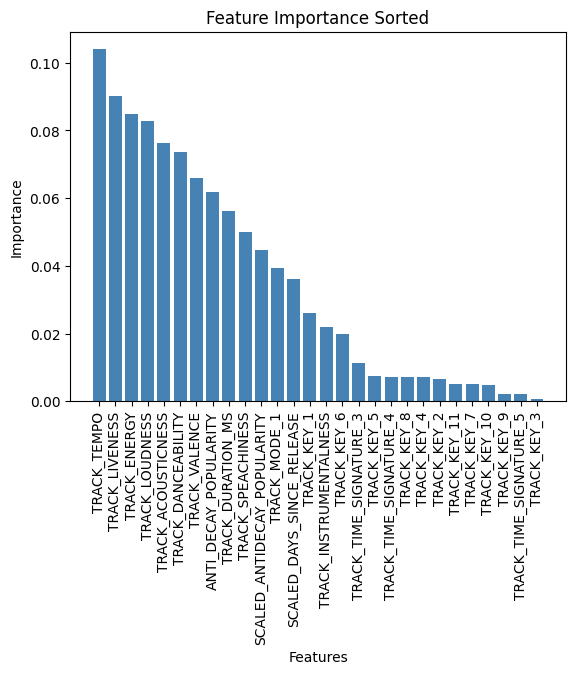

In [58]:
# Create a dictionary of features and their importances
feature_importance_dict = dict(zip(best_rf.feature_names_in_, best_rf.feature_importances_))

# Sort the dictionary by importances in descending order
sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))

# Plot the sorted feature importances
plt.bar(sorted_feature_importance.keys(), sorted_feature_importance.values(), color='steelblue')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance Sorted')
plt.show()


## Logistic Regression

              precision    recall  f1-score   support

           0       0.36      0.42      0.38        12
           1       0.56      0.50      0.53        18

    accuracy                           0.47        30
   macro avg       0.46      0.46      0.46        30
weighted avg       0.48      0.47      0.47        30



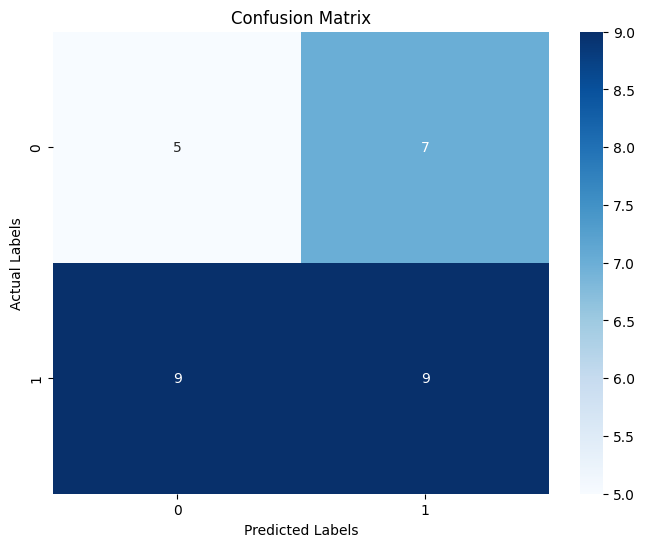

In [59]:
logit = LogisticRegression(class_weight='balanced', random_state=5, max_iter=1_000)
logit.fit(X_train_final, y_train_final.to_numpy().ravel())
logit_predict = logit.predict(X_test_final)
conf_matrix = confusion_matrix(y_test_final, logit_predict)
print(classification_report(y_test, logit_predict))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()

## Multi-Layer Perceptron

              precision    recall  f1-score   support

           0       0.50      0.33      0.40        12
           1       0.64      0.78      0.70        18

    accuracy                           0.60        30
   macro avg       0.57      0.56      0.55        30
weighted avg       0.58      0.60      0.58        30



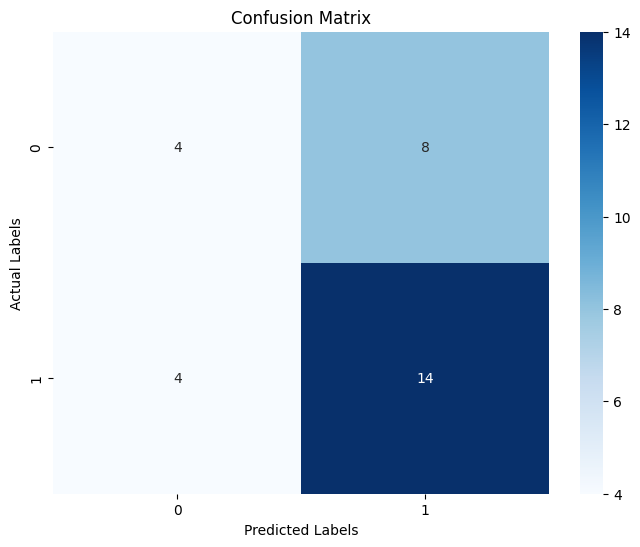

In [60]:
mlp = MLPClassifier(hidden_layer_sizes= (3, 20), activation='relu', random_state=5)
mlp.fit(X_train_final, y_train_final.to_numpy().ravel())
mlp_predict = mlp.predict(X_test_final)
conf_matrix = confusion_matrix(y_test_final, mlp_predict)
print(classification_report(y_test_final, mlp_predict))


balanced_accuracy_score(y_test_final, mlp_predict)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()

## K-Nearest Neighbors

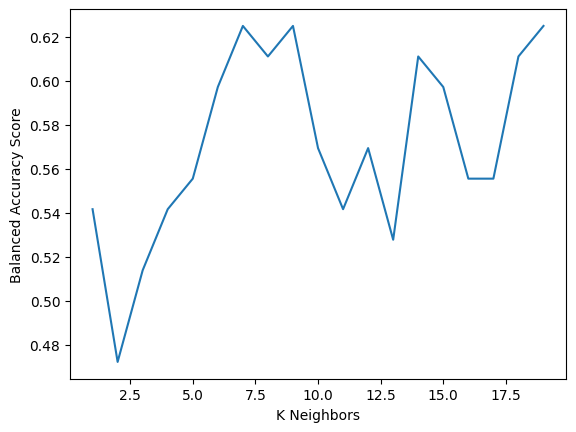

Max Balanced Accuracy : 
Neighbors: 7,
Accuracy 0.62


In [67]:
neighbors_and_accuracy = {}

best_knn = None
best_knn_accuracy = 0
best_knn_predict = None

for i in np.arange(1, 20):
    knn = KNeighborsClassifier(n_neighbors=i, weights='uniform')
    knn.fit(X_train_final, y_train_final.to_numpy().ravel())
    knn_predict = knn.predict(X_test_final)
    knn_clf_score = balanced_accuracy_score(y_test_final, knn_predict)
    neighbors_and_accuracy.setdefault(i, knn_clf_score)

    if knn_clf_score > best_knn_accuracy:
        best_knn_accuracy = knn_clf_score
        best_knn = knn
        best_knn_predict = knn_predict


fig = sns.lineplot(x=neighbors_and_accuracy.keys(), y=neighbors_and_accuracy.values())
fig.set_xlabel('K Neighbors')
fig.set_ylabel('Balanced Accuracy Score')
plt.show()
print(f"Max Balanced Accuracy : \n"
      f"Neighbors: {best_knn.n_neighbors},\n"
      f"Accuracy {best_knn_accuracy:.2f}")

              precision    recall  f1-score   support

           0       0.62      0.42      0.50        12
           1       0.68      0.83      0.75        18

    accuracy                           0.67        30
   macro avg       0.65      0.62      0.62        30
weighted avg       0.66      0.67      0.65        30



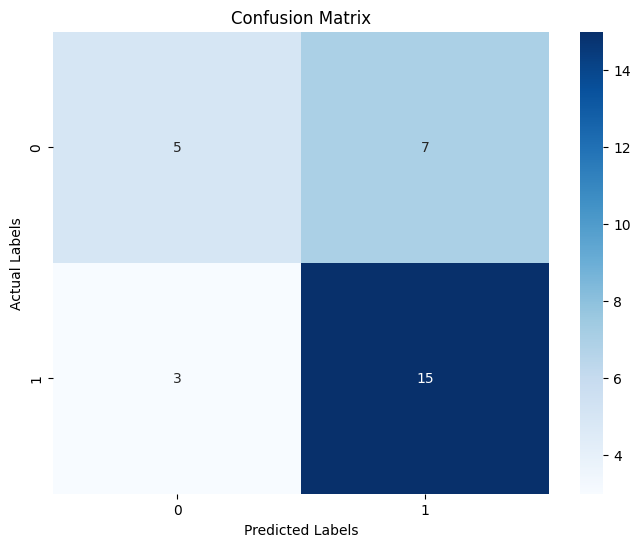

In [70]:
# KNN Confusion Matrix
conf_matrix = confusion_matrix(y_test_final, best_knn_predict)
print(classification_report(y_test_final, best_knn_predict))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()

# Closing Thoughts
Which songs did our best model get correct? <br>
Since KNN was our best model as far as balanced accuracy score, let's see exactly which songs
it guess correctled/incorrectly, instead of just random indices and values.

In [71]:
song_analysis = df_og[['TRACK_NAME', 'IS_FAVORITE']].iloc[X_test_final.index,]\
                .assign(CLF_IS_FAVORITE = best_knn_predict,
                        IS_MATCH = lambda df: df['CLF_IS_FAVORITE'] == df['IS_FAVORITE'])\
                .sort_values('IS_MATCH', ascending=False)
song_analysis

TRACK_NAME  IS_FAVORITE  CLF_IS_FAVORITE  \
34                                       DNA.            1                1   
22                                These Walls            1                1   
69  Swimming Pools (Drank) - Extended Version            1                1   
24                                   Die Hard            0                0   
13                              Purple Hearts            1                1   
63                             Auntie Diaries            0                0   
32                                    Hol' Up            1                1   
60     Poe Mans Dreams (His Vice) (feat. GLC)            1                1   
40                           The Heart Part 5            0                0   
71                         Backseat Freestyle            0                0   
37                               m.A.A.d city            1                1   
97   Sherane a.k.a Master Splinter’s Daughter            1                1   
35                                 Mr. Morale            0                0   
17                                      LUST.            1                1   
10                           meet the grahams            1                1   
23                                        N95            1                1   
74                             Poetic Justice            1                1   
28                            Wesley's Theory            1                1   
46                      For Free? - Interlude            1                1   
56                              Hood Politics            1                1   
55                                       GOD.            0                1   
39                                 Mortal Man            1                0   
66         Sing About Me, I'm Dying Of Thirst            0                1   
94                                Chapter Ten            0                1   
12                    LOYALTY. FEAT. RIHANNA.            0                1   
57                                     Mirror            1                0   
42                Blow My High (Members Only)            0                1   
70                         Savior - Interlude            1                0   
20                        LOVE. FEAT. ZACARI.            0                1   
87                  untitled 04 | 08.14.2014.            0                1   

    IS_MATCH  
34      True  
22      True  
69      True  
24      True  
13      True  
63      True  
32      True  
60      True  
40      True  
71      True  
37      True  
97      True  
35      True  
17      True  
10      True  
23      True  
74      True  
28      True  
46      True  
56      True  
55     False  
39     False  
66     False  
94     False  
12     False  
57     False  
42     False  
70     False  
20     False  
87     False

What are my final thoughts? Basically a coin flip (though maybe a little better). 
Though, credit where credit is due, I am honestly impressed at the accuracy given 
the incredible risk/error my personal opinion of whether a song was a favorite of 
mine or not. Something as simple as taking my own quiz at a later time would 
surely end in different results. So, my own predict variable would be hard to
re-create, thus, a machine learning model would struggle because it is not
privy to my own internal thought process in whether a song is truly a favorite
or not. However, as mentioned, given that and the features, it is still
able to calculate a remarkable accuracy despite this enourmous hurlde. 

What I am dissappointed in, is some of the songs it guessed as favorites when it 
wasn't a true favorite. However, those songs have A LOT of similarities with songs
I do love when I think back to the songs.

Additionally, this goes to show that it's not just the quantifiable features, but it may also
do with the words in the specific words. This would require a NLP lyrical-analysis
though, which is beyond the scope of this specific project. But perhaps something
for a future one.

Lastly, some songs I did like, but aren't a huge favorite. So, just as much
as the model "is the problem" I was also problem that was introduced into the equation
with perhaps a hard-to-reproduce scaling system. 